In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

In [2]:
nSamples=36
holdOutSamples_samples=[['HV1','P22','P14','P27'],['HV3','P46','P24','P37'],['HV5','P68','P44','P42'],['HV7','P15','P55','P59'],['HV8','P47','P63','P70'],['HV2','P57','P72','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [6]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256

In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    
    print(' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all








In [8]:
name_train='conditionClf_origImg_sampling'
modelname_train='resnet18'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

0
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7058 loss_val: 0.8646 time: 36.5840s
 Epoch: 0001 loss_train: 0.4735 loss_val: 0.6621 time: 34.6271s
 Epoch: 0002 loss_train: 0.2804 loss_val: 1.2069 time: 34.3207s
 Epoch: 0003 loss_train: 0.2001 loss_val: 1.5757 time: 34.5652s
 Epoch: 0004 loss_train: 0.1547 loss_val: 1.0273 time: 34.1690s
 Epoch: 0005 loss_train: 0.0944 loss_val: 0.9471 time: 34.4863s
 Epoch: 0006 loss_train: 0.0648 loss_val: 1.1688 time: 34.8195s
 Epoch: 0007 loss_train: 0.0513 loss_val: 0.9593 time: 33.4288s
 Epoch: 0008 loss_train: 0.0396 loss_val: 1.7937 time: 32.7911s
 Epoch: 0009 loss_train: 0.0308 loss_val: 1.1974 time: 33.3158s
 Epoch: 0010 loss_train: 0.0231 loss_val: 1.1502 time: 32.6727s
 Epoch: 0011 loss_train: 0.0202 loss_val: 1.0279 time: 32.5490s
 Epoch: 0012 loss_train: 0.0183 loss_val: 1.0906 time: 31.7550s
 Epoch: 0013 loss_train: 0.0161 loss_val: 1.1851 time: 31.1717s
 Epoch: 0014 loss_train: 0.0154 loss_val: 1.2156 time: 31.8188s
 Epoch: 0015 loss_train: 0.0166 loss_val

 Epoch: 0132 loss_train: 0.0057 loss_val: 1.4862 time: 34.9544s
 Epoch: 0133 loss_train: 0.0055 loss_val: 1.5192 time: 34.6949s
 Epoch: 0134 loss_train: 0.0070 loss_val: 1.6325 time: 34.3021s
 Epoch: 0135 loss_train: 0.0063 loss_val: 1.6080 time: 33.6343s
 Epoch: 0136 loss_train: 0.0451 loss_val: 1.6304 time: 33.3234s
 Epoch: 0137 loss_train: 0.0575 loss_val: 1.4365 time: 33.5871s
 Epoch: 0138 loss_train: 0.0172 loss_val: 1.2941 time: 35.7166s
 Epoch: 0139 loss_train: 0.0085 loss_val: 1.5452 time: 34.5315s
 Epoch: 0140 loss_train: 0.0062 loss_val: 1.4489 time: 35.4619s
 Epoch: 0141 loss_train: 0.0056 loss_val: 1.3971 time: 33.3907s
 Epoch: 0142 loss_train: 0.0053 loss_val: 1.4045 time: 31.3355s
 Epoch: 0143 loss_train: 0.0054 loss_val: 1.4154 time: 36.7507s
 Epoch: 0144 loss_train: 0.0052 loss_val: 1.4527 time: 34.9357s
 Epoch: 0145 loss_train: 0.0049 loss_val: 1.5177 time: 33.2608s
 Epoch: 0146 loss_train: 0.0047 loss_val: 1.5755 time: 31.8610s
 Epoch: 0147 loss_train: 0.0050 loss_val

 Epoch: 0261 loss_train: 0.0058 loss_val: 2.0648 time: 35.4746s
 Epoch: 0262 loss_train: 0.0572 loss_val: 1.5099 time: 28.5959s
 Epoch: 0263 loss_train: 0.0114 loss_val: 1.3560 time: 34.5665s
 Epoch: 0264 loss_train: 0.0027 loss_val: 1.4840 time: 34.5744s
 Epoch: 0265 loss_train: 0.0007 loss_val: 1.4718 time: 35.8215s
 Epoch: 0266 loss_train: 0.0005 loss_val: 1.4900 time: 33.6961s
 Epoch: 0267 loss_train: 0.0004 loss_val: 1.4970 time: 33.1948s
 Epoch: 0268 loss_train: 0.0003 loss_val: 1.5101 time: 31.1801s
 Epoch: 0269 loss_train: 0.0003 loss_val: 1.5203 time: 30.8162s
 Epoch: 0270 loss_train: 0.0003 loss_val: 1.5301 time: 29.3850s
 Epoch: 0271 loss_train: 0.0003 loss_val: 1.5390 time: 31.6311s
 Epoch: 0272 loss_train: 0.0003 loss_val: 1.5505 time: 32.3735s
 Epoch: 0273 loss_train: 0.0003 loss_val: 1.5522 time: 31.6373s
 Epoch: 0274 loss_train: 0.0003 loss_val: 1.5608 time: 32.8177s
 Epoch: 0275 loss_train: 0.0003 loss_val: 1.5724 time: 33.6008s
 Epoch: 0276 loss_train: 0.0003 loss_val

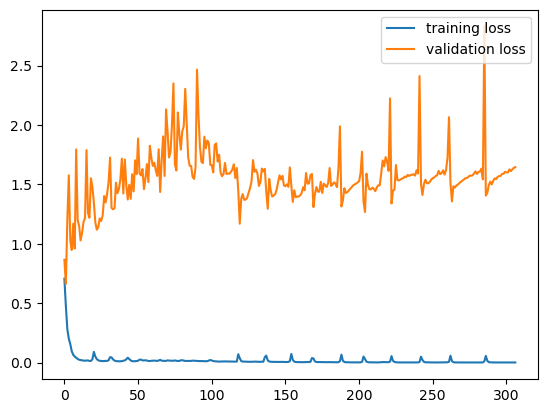

1
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7405 loss_val: 0.7710 time: 33.7394s
 Epoch: 0001 loss_train: 0.5239 loss_val: 0.6419 time: 32.4480s
 Epoch: 0002 loss_train: 0.3060 loss_val: 0.8475 time: 34.3896s
 Epoch: 0003 loss_train: 0.1658 loss_val: 1.2277 time: 35.4566s
 Epoch: 0004 loss_train: 0.1548 loss_val: 0.9056 time: 35.6365s
 Epoch: 0005 loss_train: 0.1115 loss_val: 1.2999 time: 35.8497s
 Epoch: 0006 loss_train: 0.0498 loss_val: 1.2625 time: 33.7178s
 Epoch: 0007 loss_train: 0.0235 loss_val: 1.0341 time: 34.5119s
 Epoch: 0008 loss_train: 0.0101 loss_val: 1.2348 time: 33.6847s
 Epoch: 0009 loss_train: 0.0036 loss_val: 1.0729 time: 34.1542s
 Epoch: 0010 loss_train: 0.0011 loss_val: 1.0588 time: 33.2323s
 Epoch: 0011 loss_train: 0.0006 loss_val: 1.0640 time: 35.8296s
 Epoch: 0012 loss_train: 0.0005 loss_val: 1.0721 time: 35.3906s
 Epoch: 0013 loss_train: 0.0004 loss_val: 1.0799 time: 35.2430s
 Epoch: 0014 loss_train: 0.0004 loss_val: 1.0873 time: 33.8490s
 Epoch: 0015 loss_train: 0.0003 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 1.6513 time: 32.0391s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.6562 time: 31.7582s
 Epoch: 0131 loss_train: 0.0000 loss_val: 1.6610 time: 30.5926s
 Epoch: 0132 loss_train: 0.0000 loss_val: 1.6659 time: 32.9322s
 Epoch: 0133 loss_train: 0.0000 loss_val: 1.6712 time: 36.1406s
 Epoch: 0134 loss_train: 0.0000 loss_val: 1.6756 time: 34.8093s
 Epoch: 0135 loss_train: 0.0000 loss_val: 1.6803 time: 34.9239s
 Epoch: 0136 loss_train: 0.0000 loss_val: 1.6852 time: 35.3548s
 Epoch: 0137 loss_train: 0.0000 loss_val: 1.6900 time: 33.9001s
 Epoch: 0138 loss_train: 0.0000 loss_val: 1.6945 time: 36.7220s
 Epoch: 0139 loss_train: 0.0000 loss_val: 1.6993 time: 33.9284s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.7041 time: 34.3632s
 Epoch: 0141 loss_train: 0.0000 loss_val: 1.7092 time: 33.4008s
 Epoch: 0142 loss_train: 0.0000 loss_val: 1.7137 time: 33.0061s
 Epoch: 0143 loss_train: 0.0000 loss_val: 1.7182 time: 29.7649s
 Epoch: 0144 loss_train: 0.0000 loss_val

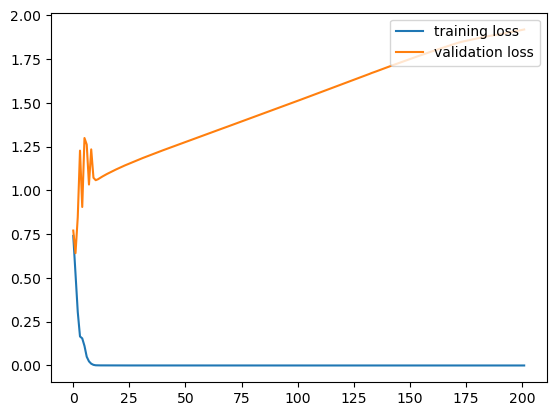

2
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7889 loss_val: 0.8061 time: 33.8035s
 Epoch: 0001 loss_train: 0.5705 loss_val: 1.0812 time: 35.2727s
 Epoch: 0002 loss_train: 0.3638 loss_val: 2.0693 time: 34.7347s
 Epoch: 0003 loss_train: 0.2147 loss_val: 1.8933 time: 36.0701s
 Epoch: 0004 loss_train: 0.1992 loss_val: 1.1769 time: 33.3285s
 Epoch: 0005 loss_train: 0.1584 loss_val: 1.0729 time: 35.3774s
 Epoch: 0006 loss_train: 0.1120 loss_val: 2.0423 time: 34.8457s
 Epoch: 0007 loss_train: 0.0941 loss_val: 1.4778 time: 33.0736s
 Epoch: 0008 loss_train: 0.0646 loss_val: 1.5727 time: 32.4377s
 Epoch: 0009 loss_train: 0.0422 loss_val: 1.4617 time: 30.7374s
 Epoch: 0010 loss_train: 0.0356 loss_val: 1.4826 time: 32.1150s
 Epoch: 0011 loss_train: 0.0301 loss_val: 1.4067 time: 32.9327s
 Epoch: 0012 loss_train: 0.0272 loss_val: 1.3424 time: 31.8805s
 Epoch: 0013 loss_train: 0.0213 loss_val: 1.4882 time: 32.5207s
 Epoch: 0014 loss_train: 0.0203 loss_val: 1.4398 time: 31.9050s
 Epoch: 0015 loss_train: 0.0191 loss_val

 Epoch: 0132 loss_train: 0.0074 loss_val: 1.9380 time: 32.0344s
 Epoch: 0133 loss_train: 0.0073 loss_val: 1.9023 time: 36.2110s
 Epoch: 0134 loss_train: 0.0076 loss_val: 1.9079 time: 35.9440s
 Epoch: 0135 loss_train: 0.0077 loss_val: 1.8744 time: 36.6935s
 Epoch: 0136 loss_train: 0.0076 loss_val: 1.8494 time: 35.7133s
 Epoch: 0137 loss_train: 0.0075 loss_val: 1.8447 time: 34.2631s
 Epoch: 0138 loss_train: 0.0079 loss_val: 1.7861 time: 36.3300s
 Epoch: 0139 loss_train: 0.0101 loss_val: 1.7351 time: 34.0670s
 Epoch: 0140 loss_train: 0.0083 loss_val: 2.1818 time: 30.8079s
 Epoch: 0141 loss_train: 0.0166 loss_val: 2.6709 time: 33.1855s
 Epoch: 0142 loss_train: 0.0710 loss_val: 1.4106 time: 37.2040s
 Epoch: 0143 loss_train: 0.0222 loss_val: 1.7992 time: 35.0489s
 Epoch: 0144 loss_train: 0.0114 loss_val: 1.7379 time: 33.6751s
 Epoch: 0145 loss_train: 0.0090 loss_val: 1.7582 time: 34.2200s
 Epoch: 0146 loss_train: 0.0076 loss_val: 1.9445 time: 33.9972s
 Epoch: 0147 loss_train: 0.0073 loss_val

 Epoch: 0261 loss_train: 0.0040 loss_val: 2.0715 time: 34.5352s
 Epoch: 0262 loss_train: 0.0037 loss_val: 2.1038 time: 36.4436s
 Epoch: 0263 loss_train: 0.0027 loss_val: 1.9405 time: 34.3528s
 Epoch: 0264 loss_train: 0.0024 loss_val: 1.9116 time: 31.5290s
 Epoch: 0265 loss_train: 0.0064 loss_val: 2.7119 time: 33.9569s
 Epoch: 0266 loss_train: 0.0521 loss_val: 1.8689 time: 33.7906s
 Epoch: 0267 loss_train: 0.0228 loss_val: 1.8140 time: 34.4329s
 Epoch: 0268 loss_train: 0.0057 loss_val: 1.8702 time: 34.8707s
 Epoch: 0269 loss_train: 0.0022 loss_val: 1.7907 time: 33.9736s
 Epoch: 0270 loss_train: 0.0012 loss_val: 1.8163 time: 34.6226s
 Epoch: 0271 loss_train: 0.0009 loss_val: 1.8349 time: 35.8049s
 Epoch: 0272 loss_train: 0.0008 loss_val: 1.8567 time: 35.1867s
 Epoch: 0273 loss_train: 0.0008 loss_val: 1.8617 time: 33.7600s
 Epoch: 0274 loss_train: 0.0009 loss_val: 1.8609 time: 31.8713s
 Epoch: 0275 loss_train: 0.0014 loss_val: 1.8531 time: 32.7320s
 Epoch: 0276 loss_train: 0.0017 loss_val

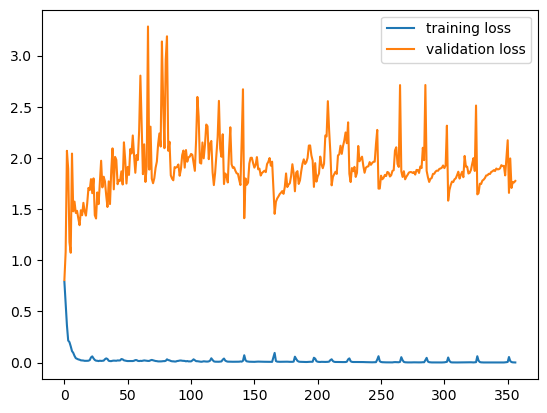

3
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7332 loss_val: 0.9481 time: 33.9606s
 Epoch: 0001 loss_train: 0.4984 loss_val: 0.7285 time: 34.0135s
 Epoch: 0002 loss_train: 0.3203 loss_val: 1.1253 time: 34.7964s
 Epoch: 0003 loss_train: 0.1992 loss_val: 1.0529 time: 32.7953s
 Epoch: 0004 loss_train: 0.1790 loss_val: 0.8545 time: 33.9807s
 Epoch: 0005 loss_train: 0.1232 loss_val: 1.0961 time: 35.0783s
 Epoch: 0006 loss_train: 0.0862 loss_val: 1.3763 time: 34.8762s
 Epoch: 0007 loss_train: 0.0568 loss_val: 1.8381 time: 33.7611s
 Epoch: 0008 loss_train: 0.0489 loss_val: 1.7838 time: 34.3342s
 Epoch: 0009 loss_train: 0.0450 loss_val: 1.4236 time: 34.3939s
 Epoch: 0010 loss_train: 0.0354 loss_val: 1.0637 time: 34.5659s
 Epoch: 0011 loss_train: 0.0294 loss_val: 1.1643 time: 34.5589s
 Epoch: 0012 loss_train: 0.0237 loss_val: 1.1173 time: 33.9828s
 Epoch: 0013 loss_train: 0.0243 loss_val: 1.2084 time: 36.1739s
 Epoch: 0014 loss_train: 0.0203 loss_val: 1.6213 time: 36.0462s
 Epoch: 0015 loss_train: 0.0217 loss_val

 Epoch: 0129 loss_train: 0.0076 loss_val: 1.6345 time: 32.2301s
 Epoch: 0130 loss_train: 0.0074 loss_val: 1.5749 time: 31.6263s
 Epoch: 0131 loss_train: 0.0076 loss_val: 1.6611 time: 30.0044s
 Epoch: 0132 loss_train: 0.0070 loss_val: 1.7415 time: 33.0580s
 Epoch: 0133 loss_train: 0.0071 loss_val: 1.8006 time: 36.0576s
 Epoch: 0134 loss_train: 0.0070 loss_val: 2.2248 time: 35.1131s
 Epoch: 0135 loss_train: 0.0085 loss_val: 2.0263 time: 35.7995s
 Epoch: 0136 loss_train: 0.0236 loss_val: 1.9170 time: 32.0871s
 Epoch: 0137 loss_train: 0.0436 loss_val: 1.6165 time: 33.3625s
 Epoch: 0138 loss_train: 0.0189 loss_val: 1.9405 time: 33.0754s
 Epoch: 0139 loss_train: 0.0105 loss_val: 1.6262 time: 35.5245s
 Epoch: 0140 loss_train: 0.0089 loss_val: 1.7452 time: 36.4727s
 Epoch: 0141 loss_train: 0.0073 loss_val: 2.1692 time: 36.0049s
 Epoch: 0142 loss_train: 0.0073 loss_val: 2.2937 time: 33.2672s
 Epoch: 0143 loss_train: 0.0087 loss_val: 1.9638 time: 35.7205s
 Epoch: 0144 loss_train: 0.0083 loss_val

 Epoch: 0258 loss_train: 0.0803 loss_val: 1.2314 time: 31.4874s
 Epoch: 0259 loss_train: 0.0205 loss_val: 1.4513 time: 31.8241s
 Epoch: 0260 loss_train: 0.0061 loss_val: 1.4183 time: 30.5157s
 Epoch: 0261 loss_train: 0.0017 loss_val: 1.4596 time: 28.1310s
 Epoch: 0262 loss_train: 0.0008 loss_val: 1.4798 time: 30.1559s
 Epoch: 0263 loss_train: 0.0006 loss_val: 1.4980 time: 34.5595s
 Epoch: 0264 loss_train: 0.0005 loss_val: 1.5074 time: 36.9329s
 Epoch: 0265 loss_train: 0.0004 loss_val: 1.5190 time: 32.3473s
 Epoch: 0266 loss_train: 0.0003 loss_val: 1.5233 time: 30.4563s
 Epoch: 0267 loss_train: 0.0003 loss_val: 1.5411 time: 34.1101s
 Epoch: 0268 loss_train: 0.0002 loss_val: 1.5505 time: 34.3949s
 Epoch: 0269 loss_train: 0.0002 loss_val: 1.5583 time: 35.0210s
 Epoch: 0270 loss_train: 0.0001 loss_val: 1.5654 time: 34.0454s
 Epoch: 0271 loss_train: 0.0001 loss_val: 1.5727 time: 33.6386s
 Epoch: 0272 loss_train: 0.0001 loss_val: 1.5798 time: 32.1676s
 Epoch: 0273 loss_train: 0.0001 loss_val

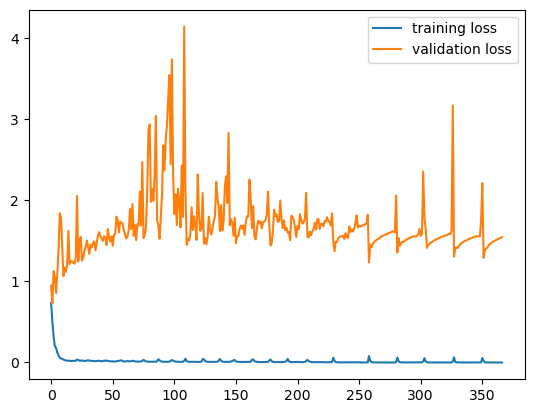

4
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7686 loss_val: 0.8728 time: 32.5238s
 Epoch: 0001 loss_train: 0.5253 loss_val: 0.6225 time: 30.7426s
 Epoch: 0002 loss_train: 0.3173 loss_val: 1.0262 time: 33.5139s
 Epoch: 0003 loss_train: 0.1849 loss_val: 0.9217 time: 31.8632s
 Epoch: 0004 loss_train: 0.1671 loss_val: 1.8101 time: 32.4220s
 Epoch: 0005 loss_train: 0.0987 loss_val: 1.1494 time: 30.5571s
 Epoch: 0006 loss_train: 0.0729 loss_val: 1.0033 time: 30.9951s
 Epoch: 0007 loss_train: 0.0542 loss_val: 1.0990 time: 33.8788s
 Epoch: 0008 loss_train: 0.0395 loss_val: 1.2968 time: 33.8537s
 Epoch: 0009 loss_train: 0.0316 loss_val: 1.0364 time: 35.2704s
 Epoch: 0010 loss_train: 0.0238 loss_val: 1.1992 time: 33.7614s
 Epoch: 0011 loss_train: 0.0197 loss_val: 1.4401 time: 33.9439s
 Epoch: 0012 loss_train: 0.0166 loss_val: 1.4022 time: 34.8539s
 Epoch: 0013 loss_train: 0.0165 loss_val: 1.6202 time: 34.2829s
 Epoch: 0014 loss_train: 0.0179 loss_val: 1.2378 time: 33.2883s
 Epoch: 0015 loss_train: 0.0212 loss_val

 Epoch: 0129 loss_train: 0.0076 loss_val: 1.7854 time: 36.9044s
 Epoch: 0130 loss_train: 0.0107 loss_val: 1.8475 time: 35.3455s
 Epoch: 0131 loss_train: 0.0258 loss_val: 1.8631 time: 34.7609s
 Epoch: 0132 loss_train: 0.0267 loss_val: 1.7144 time: 35.0253s
 Epoch: 0133 loss_train: 0.0167 loss_val: 1.6461 time: 32.5370s
 Epoch: 0134 loss_train: 0.0130 loss_val: 1.7180 time: 32.3067s
 Epoch: 0135 loss_train: 0.0106 loss_val: 1.8324 time: 33.6893s
 Epoch: 0136 loss_train: 0.0091 loss_val: 1.7809 time: 34.6374s
 Epoch: 0137 loss_train: 0.0085 loss_val: 1.7160 time: 35.2720s
 Epoch: 0138 loss_train: 0.0083 loss_val: 1.7109 time: 33.2394s
 Epoch: 0139 loss_train: 0.0093 loss_val: 1.7574 time: 34.9740s
 Epoch: 0140 loss_train: 0.0098 loss_val: 1.7120 time: 32.0125s
 Epoch: 0141 loss_train: 0.0153 loss_val: 1.6639 time: 32.1435s
 Epoch: 0142 loss_train: 0.0156 loss_val: 1.6244 time: 33.7180s
 Epoch: 0143 loss_train: 0.0206 loss_val: 2.0183 time: 33.2448s
 Epoch: 0144 loss_train: 0.0158 loss_val

 Epoch: 0258 loss_train: 0.0014 loss_val: 1.4257 time: 32.1830s
 Epoch: 0259 loss_train: 0.0011 loss_val: 1.4148 time: 32.1598s
 Epoch: 0260 loss_train: 0.0010 loss_val: 1.4223 time: 35.7202s
 Epoch: 0261 loss_train: 0.0009 loss_val: 1.4939 time: 35.0075s
 Epoch: 0262 loss_train: 0.0011 loss_val: 1.4812 time: 36.4508s
 Epoch: 0263 loss_train: 0.0012 loss_val: 1.4330 time: 34.0180s
 Epoch: 0264 loss_train: 0.0019 loss_val: 1.4869 time: 34.4442s
 Epoch: 0265 loss_train: 0.0018 loss_val: 1.3908 time: 33.1662s
 Epoch: 0266 loss_train: 0.0016 loss_val: 1.4288 time: 33.8518s
 Epoch: 0267 loss_train: 0.0020 loss_val: 1.4095 time: 31.0214s
 Epoch: 0268 loss_train: 0.0013 loss_val: 1.4360 time: 32.1044s
 Epoch: 0269 loss_train: 0.0012 loss_val: 1.4329 time: 31.5120s
 Epoch: 0270 loss_train: 0.0009 loss_val: 1.4879 time: 30.8008s
 Epoch: 0271 loss_train: 0.0012 loss_val: 1.4787 time: 33.1694s
 Epoch: 0272 loss_train: 0.0017 loss_val: 1.5810 time: 33.5273s
 Epoch: 0273 loss_train: 0.0014 loss_val

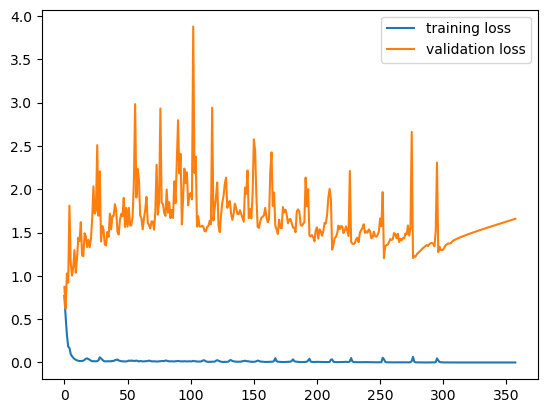

5
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7767 loss_val: 0.6495 time: 33.3646s
 Epoch: 0001 loss_train: 0.5528 loss_val: 0.9722 time: 34.3184s
 Epoch: 0002 loss_train: 0.3629 loss_val: 1.0407 time: 33.1345s
 Epoch: 0003 loss_train: 0.2153 loss_val: 1.0789 time: 34.9007s
 Epoch: 0004 loss_train: 0.1927 loss_val: 1.1926 time: 33.5950s
 Epoch: 0005 loss_train: 0.1346 loss_val: 0.9617 time: 35.4698s
 Epoch: 0006 loss_train: 0.0825 loss_val: 0.9839 time: 35.9525s
 Epoch: 0007 loss_train: 0.0534 loss_val: 1.5160 time: 31.6094s
 Epoch: 0008 loss_train: 0.0449 loss_val: 1.4634 time: 34.8106s
 Epoch: 0009 loss_train: 0.0387 loss_val: 1.4500 time: 32.5889s
 Epoch: 0010 loss_train: 0.0327 loss_val: 1.7537 time: 34.6825s
 Epoch: 0011 loss_train: 0.0285 loss_val: 1.7333 time: 36.6511s
 Epoch: 0012 loss_train: 0.0226 loss_val: 1.6779 time: 34.1040s
 Epoch: 0013 loss_train: 0.0229 loss_val: 1.4294 time: 33.7342s
 Epoch: 0014 loss_train: 0.0210 loss_val: 1.5910 time: 33.6872s
 Epoch: 0015 loss_train: 0.0180 loss_val

 Epoch: 0129 loss_train: 0.0065 loss_val: 1.6617 time: 32.8084s
 Epoch: 0130 loss_train: 0.0162 loss_val: 2.3142 time: 32.0508s
 Epoch: 0131 loss_train: 0.0668 loss_val: 1.2027 time: 31.8032s
 Epoch: 0132 loss_train: 0.0258 loss_val: 1.2840 time: 32.6159s
 Epoch: 0133 loss_train: 0.0132 loss_val: 1.4211 time: 32.4126s
 Epoch: 0134 loss_train: 0.0085 loss_val: 1.4810 time: 30.1433s
 Epoch: 0135 loss_train: 0.0070 loss_val: 1.3444 time: 33.7658s
 Epoch: 0136 loss_train: 0.0061 loss_val: 1.3954 time: 33.6637s
 Epoch: 0137 loss_train: 0.0060 loss_val: 1.4546 time: 36.2620s
 Epoch: 0138 loss_train: 0.0057 loss_val: 1.7169 time: 36.0380s
 Epoch: 0139 loss_train: 0.0056 loss_val: 1.5192 time: 35.3104s
 Epoch: 0140 loss_train: 0.0054 loss_val: 1.3925 time: 34.3881s
 Epoch: 0141 loss_train: 0.0047 loss_val: 1.5019 time: 31.8647s
 Epoch: 0142 loss_train: 0.0049 loss_val: 1.6461 time: 33.7457s
 Epoch: 0143 loss_train: 0.0050 loss_val: 1.6171 time: 30.1794s
 Epoch: 0144 loss_train: 0.0062 loss_val

 Epoch: 0258 loss_train: 0.0000 loss_val: 1.6010 time: 34.8457s
 Epoch: 0259 loss_train: 0.0000 loss_val: 1.6053 time: 34.7490s
 Epoch: 0260 loss_train: 0.0000 loss_val: 1.6096 time: 32.8462s
 Epoch: 0261 loss_train: 0.0000 loss_val: 1.6138 time: 33.1463s
 Epoch: 0262 loss_train: 0.0000 loss_val: 1.6180 time: 32.0021s
 Epoch: 0263 loss_train: 0.0000 loss_val: 1.6221 time: 35.2742s
 Epoch: 0264 loss_train: 0.0000 loss_val: 1.6261 time: 34.2788s
 Epoch: 0265 loss_train: 0.0000 loss_val: 1.6302 time: 33.7598s
 Epoch: 0266 loss_train: 0.0000 loss_val: 1.6343 time: 35.0721s
 Epoch: 0267 loss_train: 0.0000 loss_val: 1.6386 time: 36.4759s
 Epoch: 0268 loss_train: 0.0000 loss_val: 1.6426 time: 35.3878s
 Epoch: 0269 loss_train: 0.0000 loss_val: 1.6467 time: 35.5268s
 Epoch: 0270 loss_train: 0.0000 loss_val: 1.6507 time: 37.3512s
 Epoch: 0271 loss_train: 0.0000 loss_val: 1.6547 time: 34.6137s
 Epoch: 0272 loss_train: 0.0000 loss_val: 1.6588 time: 32.9078s
 Epoch: 0273 loss_train: 0.0000 loss_val

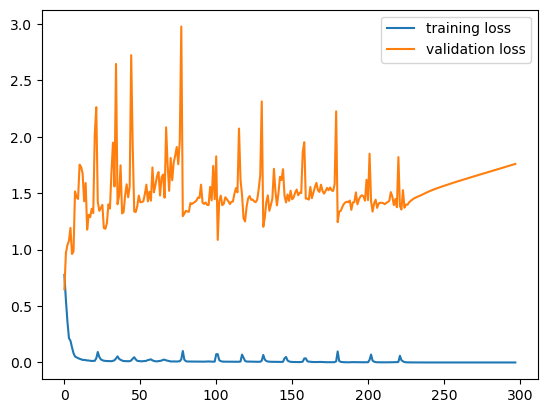

6
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7121 loss_val: 0.6078 time: 33.3410s
 Epoch: 0001 loss_train: 0.4783 loss_val: 0.6192 time: 34.5924s
 Epoch: 0002 loss_train: 0.2825 loss_val: 0.7533 time: 36.6038s
 Epoch: 0003 loss_train: 0.1822 loss_val: 1.2017 time: 34.0209s
 Epoch: 0004 loss_train: 0.1739 loss_val: 0.9886 time: 35.8932s
 Epoch: 0005 loss_train: 0.0974 loss_val: 1.6035 time: 35.2518s
 Epoch: 0006 loss_train: 0.0578 loss_val: 1.2404 time: 35.1699s
 Epoch: 0007 loss_train: 0.0385 loss_val: 1.1589 time: 30.8860s
 Epoch: 0008 loss_train: 0.0304 loss_val: 1.2912 time: 29.0073s
 Epoch: 0009 loss_train: 0.0255 loss_val: 0.9770 time: 31.3561s
 Epoch: 0010 loss_train: 0.0197 loss_val: 0.9906 time: 31.7684s
 Epoch: 0011 loss_train: 0.0161 loss_val: 1.0112 time: 36.0473s
 Epoch: 0012 loss_train: 0.0142 loss_val: 1.0040 time: 34.6001s
 Epoch: 0013 loss_train: 0.0131 loss_val: 1.0761 time: 35.2777s
 Epoch: 0014 loss_train: 0.0127 loss_val: 1.1431 time: 34.8272s
 Epoch: 0015 loss_train: 0.0121 loss_val

 Epoch: 0129 loss_train: 0.0050 loss_val: 1.1822 time: 35.2440s
 Epoch: 0130 loss_train: 0.0040 loss_val: 1.1960 time: 33.8169s
 Epoch: 0131 loss_train: 0.0035 loss_val: 1.1949 time: 34.0687s
 Epoch: 0132 loss_train: 0.0033 loss_val: 1.1933 time: 35.4985s
 Epoch: 0133 loss_train: 0.0031 loss_val: 1.2489 time: 31.7978s
 Epoch: 0134 loss_train: 0.0035 loss_val: 1.4465 time: 34.8090s
 Epoch: 0135 loss_train: 0.0043 loss_val: 1.2140 time: 34.3654s
 Epoch: 0136 loss_train: 0.0032 loss_val: 1.2568 time: 34.1337s
 Epoch: 0137 loss_train: 0.0040 loss_val: 1.2428 time: 32.5471s
 Epoch: 0138 loss_train: 0.0045 loss_val: 1.1775 time: 31.1957s
 Epoch: 0139 loss_train: 0.0052 loss_val: 1.2319 time: 32.9470s
 Epoch: 0140 loss_train: 0.0036 loss_val: 1.3340 time: 30.3999s
 Epoch: 0141 loss_train: 0.0025 loss_val: 1.3190 time: 32.8727s
 Epoch: 0142 loss_train: 0.0020 loss_val: 1.3204 time: 33.4046s
 Epoch: 0143 loss_train: 0.0018 loss_val: 1.3305 time: 33.3796s
 Epoch: 0144 loss_train: 0.0018 loss_val

 Epoch: 0258 loss_train: 0.0001 loss_val: 1.3226 time: 34.3809s
 Epoch: 0259 loss_train: 0.0001 loss_val: 1.3288 time: 34.3997s
 Epoch: 0260 loss_train: 0.0001 loss_val: 1.3336 time: 33.5401s
 Epoch: 0261 loss_train: 0.0001 loss_val: 1.3391 time: 34.9222s
 Epoch: 0262 loss_train: 0.0001 loss_val: 1.3430 time: 35.5384s
 Epoch: 0263 loss_train: 0.0001 loss_val: 1.3492 time: 35.9302s
 Epoch: 0264 loss_train: 0.0001 loss_val: 1.3507 time: 34.1678s
 Epoch: 0265 loss_train: 0.0001 loss_val: 1.3580 time: 31.1867s
 Epoch: 0266 loss_train: 0.0001 loss_val: 1.3592 time: 31.7322s
 Epoch: 0267 loss_train: 0.0001 loss_val: 1.3609 time: 31.5811s
 Epoch: 0268 loss_train: 0.0001 loss_val: 1.3604 time: 31.8879s
 Epoch: 0269 loss_train: 0.0007 loss_val: 1.4508 time: 34.6194s
 Epoch: 0270 loss_train: 0.0308 loss_val: 1.5503 time: 32.9461s
 Epoch: 0271 loss_train: 0.0644 loss_val: 0.9938 time: 32.5340s
 Epoch: 0272 loss_train: 0.0107 loss_val: 1.1752 time: 30.7818s
 Epoch: 0273 loss_train: 0.0038 loss_val

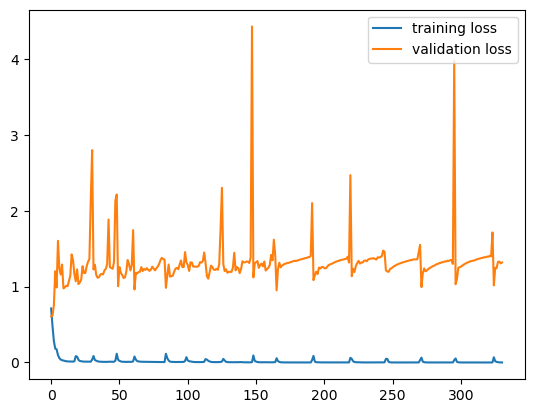

7
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7394 loss_val: 1.1923 time: 37.4881s
 Epoch: 0001 loss_train: 0.5174 loss_val: 1.6836 time: 32.0223s
 Epoch: 0002 loss_train: 0.2983 loss_val: 2.6272 time: 34.3934s
 Epoch: 0003 loss_train: 0.1803 loss_val: 1.3443 time: 32.5702s
 Epoch: 0004 loss_train: 0.1447 loss_val: 1.1510 time: 34.9441s
 Epoch: 0005 loss_train: 0.1168 loss_val: 1.0294 time: 34.7238s
 Epoch: 0006 loss_train: 0.0548 loss_val: 0.9932 time: 34.3074s
 Epoch: 0007 loss_train: 0.0241 loss_val: 1.0366 time: 35.5281s
 Epoch: 0008 loss_train: 0.0148 loss_val: 1.0544 time: 31.9789s
 Epoch: 0009 loss_train: 0.0057 loss_val: 1.0429 time: 31.5810s
 Epoch: 0010 loss_train: 0.0017 loss_val: 1.0443 time: 30.8560s
 Epoch: 0011 loss_train: 0.0008 loss_val: 1.0458 time: 31.0179s
 Epoch: 0012 loss_train: 0.0006 loss_val: 1.0464 time: 30.0821s
 Epoch: 0013 loss_train: 0.0005 loss_val: 1.0531 time: 32.7737s
 Epoch: 0014 loss_train: 0.0004 loss_val: 1.0596 time: 27.9543s
 Epoch: 0015 loss_train: 0.0004 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 1.5903 time: 30.4389s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5947 time: 30.5364s
 Epoch: 0131 loss_train: 0.0000 loss_val: 1.5993 time: 29.1399s
 Epoch: 0132 loss_train: 0.0000 loss_val: 1.6040 time: 29.9417s
 Epoch: 0133 loss_train: 0.0000 loss_val: 1.6087 time: 27.5997s
 Epoch: 0134 loss_train: 0.0000 loss_val: 1.6133 time: 29.7212s
 Epoch: 0135 loss_train: 0.0000 loss_val: 1.6178 time: 29.1708s
 Epoch: 0136 loss_train: 0.0000 loss_val: 1.6224 time: 28.5479s
 Epoch: 0137 loss_train: 0.0000 loss_val: 1.6269 time: 29.2140s
 Epoch: 0138 loss_train: 0.0000 loss_val: 1.6316 time: 30.6579s
 Epoch: 0139 loss_train: 0.0000 loss_val: 1.6360 time: 29.0098s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6406 time: 28.6449s
 Epoch: 0141 loss_train: 0.0000 loss_val: 1.6450 time: 30.5259s
 Epoch: 0142 loss_train: 0.0000 loss_val: 1.6496 time: 26.9931s
 Epoch: 0143 loss_train: 0.0000 loss_val: 1.6542 time: 28.2977s
 Epoch: 0144 loss_train: 0.0000 loss_val

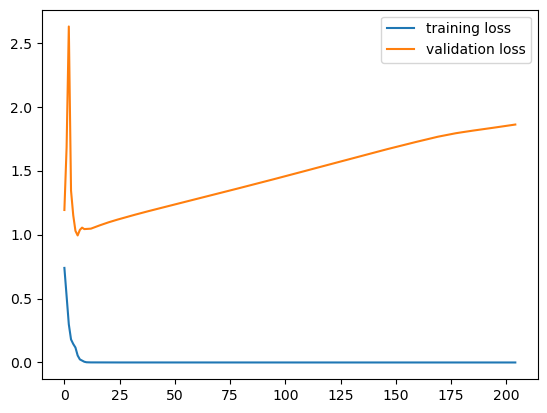

8
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7928 loss_val: 0.7892 time: 33.7912s
 Epoch: 0001 loss_train: 0.5696 loss_val: 0.7411 time: 33.4356s
 Epoch: 0002 loss_train: 0.3776 loss_val: 1.1581 time: 32.6122s
 Epoch: 0003 loss_train: 0.2219 loss_val: 2.7717 time: 32.4897s
 Epoch: 0004 loss_train: 0.2071 loss_val: 1.4256 time: 33.5331s
 Epoch: 0005 loss_train: 0.1532 loss_val: 1.2819 time: 34.3578s
 Epoch: 0006 loss_train: 0.0979 loss_val: 1.4707 time: 33.9751s
 Epoch: 0007 loss_train: 0.0627 loss_val: 1.3705 time: 33.1557s
 Epoch: 0008 loss_train: 0.0444 loss_val: 1.1437 time: 35.4814s
 Epoch: 0009 loss_train: 0.0334 loss_val: 1.4537 time: 33.7380s
 Epoch: 0010 loss_train: 0.0314 loss_val: 1.6089 time: 32.9834s
 Epoch: 0011 loss_train: 0.0271 loss_val: 1.5951 time: 32.2325s
 Epoch: 0012 loss_train: 0.0234 loss_val: 1.3321 time: 34.4716s
 Epoch: 0013 loss_train: 0.0210 loss_val: 1.3364 time: 33.3630s
 Epoch: 0014 loss_train: 0.0199 loss_val: 1.5046 time: 34.4826s
 Epoch: 0015 loss_train: 0.0165 loss_val

 Epoch: 0129 loss_train: 0.0062 loss_val: 1.7236 time: 38.6197s
 Epoch: 0130 loss_train: 0.0061 loss_val: 1.7659 time: 36.6072s
 Epoch: 0131 loss_train: 0.0065 loss_val: 1.7943 time: 35.7817s
 Epoch: 0132 loss_train: 0.0077 loss_val: 1.7677 time: 35.4932s
 Epoch: 0133 loss_train: 0.0076 loss_val: 1.7979 time: 34.8348s
 Epoch: 0134 loss_train: 0.0101 loss_val: 1.8870 time: 34.6406s
 Epoch: 0135 loss_train: 0.0136 loss_val: 1.8383 time: 35.2829s
 Epoch: 0136 loss_train: 0.0550 loss_val: 1.6002 time: 35.8243s
 Epoch: 0137 loss_train: 0.0269 loss_val: 1.6336 time: 34.3881s
 Epoch: 0138 loss_train: 0.0112 loss_val: 1.7368 time: 34.5067s
 Epoch: 0139 loss_train: 0.0075 loss_val: 1.7833 time: 34.1188s
 Epoch: 0140 loss_train: 0.0064 loss_val: 1.7747 time: 37.1539s
 Epoch: 0141 loss_train: 0.0060 loss_val: 1.7107 time: 36.6094s
 Epoch: 0142 loss_train: 0.0052 loss_val: 1.7504 time: 36.0198s
 Epoch: 0143 loss_train: 0.0053 loss_val: 1.7676 time: 34.4745s
 Epoch: 0144 loss_train: 0.0066 loss_val

 Epoch: 0258 loss_train: 0.0047 loss_val: 1.6935 time: 35.0559s
 Epoch: 0259 loss_train: 0.0029 loss_val: 1.7181 time: 36.3736s
 Epoch: 0260 loss_train: 0.0027 loss_val: 1.7751 time: 35.4556s
 Epoch: 0261 loss_train: 0.0029 loss_val: 1.8264 time: 35.7749s
 Epoch: 0262 loss_train: 0.0025 loss_val: 1.8163 time: 36.3545s
 Epoch: 0263 loss_train: 0.0019 loss_val: 1.9286 time: 34.8227s
 Epoch: 0264 loss_train: 0.0020 loss_val: 1.9050 time: 36.9461s
 Epoch: 0265 loss_train: 0.0021 loss_val: 1.8700 time: 35.7394s
 Epoch: 0266 loss_train: 0.0024 loss_val: 1.8188 time: 37.6237s
 Epoch: 0267 loss_train: 0.0027 loss_val: 1.8343 time: 35.5832s
 Epoch: 0268 loss_train: 0.0036 loss_val: 1.8377 time: 35.7525s
 Epoch: 0269 loss_train: 0.0046 loss_val: 2.2735 time: 36.5994s
 Epoch: 0270 loss_train: 0.0037 loss_val: 1.8305 time: 34.7543s
 Epoch: 0271 loss_train: 0.0040 loss_val: 2.5657 time: 34.4314s
 Epoch: 0272 loss_train: 0.0044 loss_val: 2.4056 time: 35.7230s
 Epoch: 0273 loss_train: 0.0229 loss_val

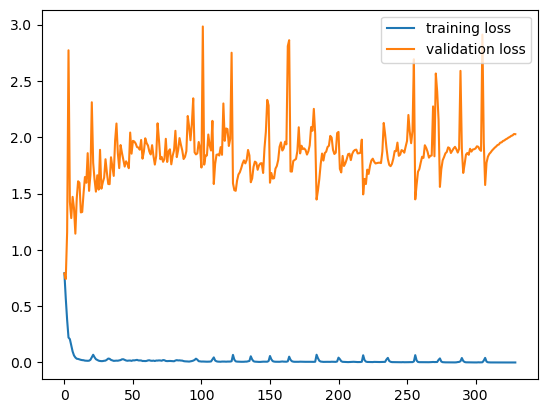

9
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7403 loss_val: 0.8330 time: 36.0649s
 Epoch: 0001 loss_train: 0.4917 loss_val: 0.9320 time: 36.8112s
 Epoch: 0002 loss_train: 0.3114 loss_val: 1.1389 time: 37.0205s
 Epoch: 0003 loss_train: 0.1818 loss_val: 1.5095 time: 36.7089s
 Epoch: 0004 loss_train: 0.1478 loss_val: 1.4108 time: 35.0946s
 Epoch: 0005 loss_train: 0.1223 loss_val: 1.1736 time: 35.8968s
 Epoch: 0006 loss_train: 0.0854 loss_val: 1.1220 time: 36.7289s
 Epoch: 0007 loss_train: 0.0654 loss_val: 1.2020 time: 38.9379s
 Epoch: 0008 loss_train: 0.0509 loss_val: 1.1986 time: 37.6469s
 Epoch: 0009 loss_train: 0.0447 loss_val: 1.3938 time: 36.9318s
 Epoch: 0010 loss_train: 0.0351 loss_val: 1.2427 time: 35.2405s
 Epoch: 0011 loss_train: 0.0305 loss_val: 1.1999 time: 37.7248s
 Epoch: 0012 loss_train: 0.0266 loss_val: 1.5040 time: 34.6746s
 Epoch: 0013 loss_train: 0.0236 loss_val: 1.4659 time: 34.6157s
 Epoch: 0014 loss_train: 0.0223 loss_val: 1.3489 time: 34.9897s
 Epoch: 0015 loss_train: 0.0201 loss_val

 Epoch: 0129 loss_train: 0.0047 loss_val: 1.9061 time: 37.8396s
 Epoch: 0130 loss_train: 0.0063 loss_val: 2.1379 time: 35.5719s
 Epoch: 0131 loss_train: 0.0247 loss_val: 1.9810 time: 37.2985s
 Epoch: 0132 loss_train: 0.0374 loss_val: 1.5942 time: 39.4837s
 Epoch: 0133 loss_train: 0.0169 loss_val: 1.4454 time: 38.5381s
 Epoch: 0134 loss_train: 0.0072 loss_val: 1.5156 time: 37.9262s
 Epoch: 0135 loss_train: 0.0053 loss_val: 1.4781 time: 34.8687s
 Epoch: 0136 loss_train: 0.0044 loss_val: 1.6128 time: 36.8728s
 Epoch: 0137 loss_train: 0.0039 loss_val: 1.5854 time: 37.3217s
 Epoch: 0138 loss_train: 0.0037 loss_val: 1.5608 time: 35.7310s
 Epoch: 0139 loss_train: 0.0040 loss_val: 1.6827 time: 35.8101s
 Epoch: 0140 loss_train: 0.0064 loss_val: 1.6362 time: 34.7793s
 Epoch: 0141 loss_train: 0.0055 loss_val: 1.5917 time: 35.9116s
 Epoch: 0142 loss_train: 0.0050 loss_val: 1.5709 time: 35.9017s
 Epoch: 0143 loss_train: 0.0043 loss_val: 1.7972 time: 34.8108s
 Epoch: 0144 loss_train: 0.0044 loss_val

 Epoch: 0258 loss_train: 0.0003 loss_val: 1.5891 time: 35.5014s
 Epoch: 0259 loss_train: 0.0016 loss_val: 1.5756 time: 37.6208s
 Epoch: 0260 loss_train: 0.0095 loss_val: 1.8761 time: 36.8565s
 Epoch: 0261 loss_train: 0.0742 loss_val: 1.2010 time: 36.2561s
 Epoch: 0262 loss_train: 0.0137 loss_val: 1.2475 time: 38.0551s
 Epoch: 0263 loss_train: 0.0030 loss_val: 1.3798 time: 36.6839s
 Epoch: 0264 loss_train: 0.0011 loss_val: 1.3623 time: 36.9688s
 Epoch: 0265 loss_train: 0.0006 loss_val: 1.3867 time: 35.5424s
 Epoch: 0266 loss_train: 0.0004 loss_val: 1.4055 time: 37.9456s
 Epoch: 0267 loss_train: 0.0003 loss_val: 1.4194 time: 37.1263s
 Epoch: 0268 loss_train: 0.0003 loss_val: 1.4296 time: 36.1563s
 Epoch: 0269 loss_train: 0.0003 loss_val: 1.4393 time: 35.8681s
 Epoch: 0270 loss_train: 0.0003 loss_val: 1.4482 time: 38.4527s
 Epoch: 0271 loss_train: 0.0003 loss_val: 1.4531 time: 36.8836s
 Epoch: 0272 loss_train: 0.0002 loss_val: 1.4643 time: 36.8826s
 Epoch: 0273 loss_train: 0.0002 loss_val

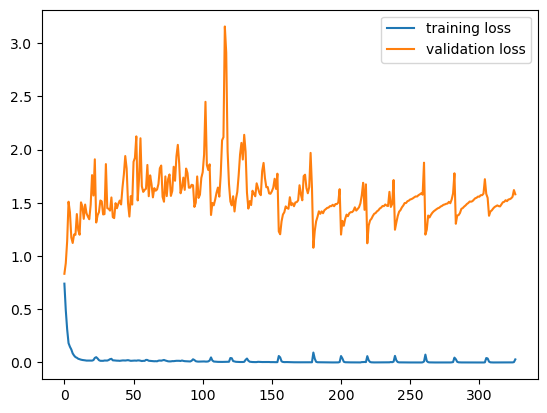

10
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7755 loss_val: 0.7272 time: 35.0768s
 Epoch: 0001 loss_train: 0.5390 loss_val: 0.6926 time: 36.5326s
 Epoch: 0002 loss_train: 0.3270 loss_val: 0.8109 time: 38.7512s
 Epoch: 0003 loss_train: 0.1896 loss_val: 1.3913 time: 38.1174s
 Epoch: 0004 loss_train: 0.1879 loss_val: 1.6526 time: 35.8478s
 Epoch: 0005 loss_train: 0.1174 loss_val: 1.0141 time: 36.6757s
 Epoch: 0006 loss_train: 0.0796 loss_val: 1.1540 time: 37.7357s
 Epoch: 0007 loss_train: 0.0656 loss_val: 2.0361 time: 34.9852s
 Epoch: 0008 loss_train: 0.0468 loss_val: 1.1856 time: 35.6343s
 Epoch: 0009 loss_train: 0.0350 loss_val: 1.2980 time: 33.1757s
 Epoch: 0010 loss_train: 0.0331 loss_val: 1.5910 time: 35.7474s
 Epoch: 0011 loss_train: 0.0314 loss_val: 1.3650 time: 38.0402s
 Epoch: 0012 loss_train: 0.0282 loss_val: 1.8061 time: 37.3577s
 Epoch: 0013 loss_train: 0.0279 loss_val: 1.3229 time: 36.9079s
 Epoch: 0014 loss_train: 0.0252 loss_val: 1.3662 time: 38.7572s
 Epoch: 0015 loss_train: 0.0250 loss_val

 Epoch: 0129 loss_train: 0.0153 loss_val: 1.4401 time: 36.5523s
 Epoch: 0130 loss_train: 0.0080 loss_val: 1.2944 time: 36.0705s
 Epoch: 0131 loss_train: 0.0061 loss_val: 1.3459 time: 36.6629s
 Epoch: 0132 loss_train: 0.0055 loss_val: 1.3495 time: 37.2407s
 Epoch: 0133 loss_train: 0.0049 loss_val: 1.3562 time: 36.9287s
 Epoch: 0134 loss_train: 0.0044 loss_val: 1.3716 time: 36.3035s
 Epoch: 0135 loss_train: 0.0040 loss_val: 1.4163 time: 37.4859s
 Epoch: 0136 loss_train: 0.0041 loss_val: 1.4408 time: 35.1344s
 Epoch: 0137 loss_train: 0.0049 loss_val: 1.4376 time: 35.9108s
 Epoch: 0138 loss_train: 0.0052 loss_val: 1.5580 time: 36.0236s
 Epoch: 0139 loss_train: 0.0062 loss_val: 1.8031 time: 37.3341s
 Epoch: 0140 loss_train: 0.0071 loss_val: 3.2108 time: 36.6148s
 Epoch: 0141 loss_train: 0.0083 loss_val: 2.0116 time: 35.2956s
 Epoch: 0142 loss_train: 0.0463 loss_val: 4.2325 time: 36.3117s
 Epoch: 0143 loss_train: 0.0509 loss_val: 1.6891 time: 35.8423s
 Epoch: 0144 loss_train: 0.0161 loss_val

 Epoch: 0258 loss_train: 0.0004 loss_val: 1.4785 time: 36.0713s
 Epoch: 0259 loss_train: 0.0005 loss_val: 1.4835 time: 37.6049s
 Epoch: 0260 loss_train: 0.0004 loss_val: 1.4864 time: 35.5884s
 Epoch: 0261 loss_train: 0.0005 loss_val: 1.4966 time: 34.9149s
 Epoch: 0262 loss_train: 0.0004 loss_val: 1.4969 time: 35.4899s
 Epoch: 0263 loss_train: 0.0005 loss_val: 1.5103 time: 34.8864s
 Epoch: 0264 loss_train: 0.0004 loss_val: 1.5122 time: 36.7911s
 Epoch: 0265 loss_train: 0.0005 loss_val: 1.5039 time: 34.6321s
 Epoch: 0266 loss_train: 0.0004 loss_val: 1.5286 time: 35.2671s
 Epoch: 0267 loss_train: 0.0004 loss_val: 1.5138 time: 37.3298s
 Epoch: 0268 loss_train: 0.0004 loss_val: 1.5223 time: 35.7549s
 Epoch: 0269 loss_train: 0.0005 loss_val: 1.5382 time: 37.1048s
 Epoch: 0270 loss_train: 0.0022 loss_val: 1.5963 time: 36.1393s
 Epoch: 0271 loss_train: 0.0670 loss_val: 1.1314 time: 35.4908s
 Epoch: 0272 loss_train: 0.0297 loss_val: 1.1911 time: 36.3951s
 Epoch: 0273 loss_train: 0.0077 loss_val

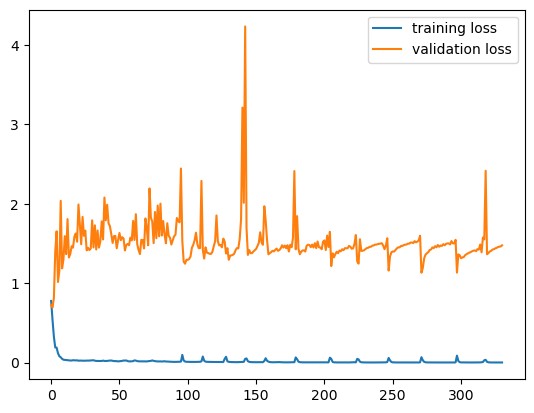

11
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7742 loss_val: 0.8006 time: 38.3467s
 Epoch: 0001 loss_train: 0.5491 loss_val: 0.7540 time: 37.4578s
 Epoch: 0002 loss_train: 0.3515 loss_val: 0.7840 time: 36.5928s
 Epoch: 0003 loss_train: 0.1984 loss_val: 1.8360 time: 37.3668s
 Epoch: 0004 loss_train: 0.1806 loss_val: 1.4604 time: 35.5640s
 Epoch: 0005 loss_train: 0.1368 loss_val: 1.2212 time: 35.5748s
 Epoch: 0006 loss_train: 0.0804 loss_val: 1.1329 time: 35.5016s
 Epoch: 0007 loss_train: 0.0622 loss_val: 1.3263 time: 36.0983s
 Epoch: 0008 loss_train: 0.0459 loss_val: 1.0666 time: 37.6282s
 Epoch: 0009 loss_train: 0.0309 loss_val: 1.2609 time: 36.7195s
 Epoch: 0010 loss_train: 0.0259 loss_val: 2.2591 time: 37.0427s
 Epoch: 0011 loss_train: 0.0237 loss_val: 1.2869 time: 36.2534s
 Epoch: 0012 loss_train: 0.0228 loss_val: 1.2951 time: 36.6347s
 Epoch: 0013 loss_train: 0.0204 loss_val: 1.4375 time: 36.3509s
 Epoch: 0014 loss_train: 0.0205 loss_val: 1.2919 time: 36.5748s
 Epoch: 0015 loss_train: 0.0212 loss_val

 Epoch: 0129 loss_train: 0.0849 loss_val: 1.2013 time: 36.0136s
 Epoch: 0130 loss_train: 0.0223 loss_val: 1.3175 time: 37.2988s
 Epoch: 0131 loss_train: 0.0131 loss_val: 1.5362 time: 37.0874s
 Epoch: 0132 loss_train: 0.0096 loss_val: 1.4584 time: 36.8606s
 Epoch: 0133 loss_train: 0.0083 loss_val: 1.4158 time: 34.7090s
 Epoch: 0134 loss_train: 0.0079 loss_val: 1.4324 time: 36.2212s
 Epoch: 0135 loss_train: 0.0078 loss_val: 1.6563 time: 37.2592s
 Epoch: 0136 loss_train: 0.0082 loss_val: 1.6119 time: 36.3553s
 Epoch: 0137 loss_train: 0.0072 loss_val: 1.6440 time: 37.7152s
 Epoch: 0138 loss_train: 0.0091 loss_val: 1.5837 time: 35.4779s
 Epoch: 0139 loss_train: 0.0090 loss_val: 1.5724 time: 36.2652s
 Epoch: 0140 loss_train: 0.0079 loss_val: 1.6397 time: 33.7843s
 Epoch: 0141 loss_train: 0.0075 loss_val: 1.6301 time: 37.6093s
 Epoch: 0142 loss_train: 0.0072 loss_val: 1.7894 time: 35.7825s
 Epoch: 0143 loss_train: 0.0079 loss_val: 2.2609 time: 35.1689s
 Epoch: 0144 loss_train: 0.0096 loss_val

 Epoch: 0258 loss_train: 0.0005 loss_val: 1.4368 time: 36.1780s
 Epoch: 0259 loss_train: 0.0005 loss_val: 1.4406 time: 37.4182s
 Epoch: 0260 loss_train: 0.0004 loss_val: 1.4563 time: 35.5490s
 Epoch: 0261 loss_train: 0.0003 loss_val: 1.4624 time: 35.9356s
 Epoch: 0262 loss_train: 0.0003 loss_val: 1.4695 time: 34.7855s
 Epoch: 0263 loss_train: 0.0002 loss_val: 1.4743 time: 37.3795s
 Epoch: 0264 loss_train: 0.0002 loss_val: 1.4803 time: 34.9258s
 Epoch: 0265 loss_train: 0.0002 loss_val: 1.4854 time: 35.6233s
 Epoch: 0266 loss_train: 0.0002 loss_val: 1.4881 time: 35.9252s
 Epoch: 0267 loss_train: 0.0001 loss_val: 1.4935 time: 37.4091s
 Epoch: 0268 loss_train: 0.0001 loss_val: 1.5008 time: 35.1061s
 Epoch: 0269 loss_train: 0.0001 loss_val: 1.5052 time: 37.1770s
 Epoch: 0270 loss_train: 0.0001 loss_val: 1.5096 time: 38.5869s
 Epoch: 0271 loss_train: 0.0001 loss_val: 1.5144 time: 36.5354s
 Epoch: 0272 loss_train: 0.0001 loss_val: 1.5196 time: 35.6585s
 Epoch: 0273 loss_train: 0.0001 loss_val

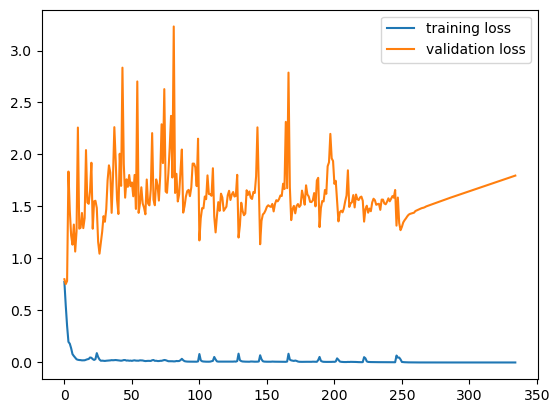

12
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7040 loss_val: 0.6569 time: 36.6872s
 Epoch: 0001 loss_train: 0.4759 loss_val: 0.8595 time: 34.4390s
 Epoch: 0002 loss_train: 0.2865 loss_val: 1.1323 time: 35.0863s
 Epoch: 0003 loss_train: 0.1905 loss_val: 1.0588 time: 36.8082s
 Epoch: 0004 loss_train: 0.1495 loss_val: 0.9760 time: 36.4632s
 Epoch: 0005 loss_train: 0.0937 loss_val: 1.0597 time: 35.7697s
 Epoch: 0006 loss_train: 0.0654 loss_val: 1.4267 time: 35.3776s
 Epoch: 0007 loss_train: 0.0459 loss_val: 1.0339 time: 36.2988s
 Epoch: 0008 loss_train: 0.0341 loss_val: 1.0662 time: 35.5396s
 Epoch: 0009 loss_train: 0.0276 loss_val: 1.0863 time: 35.1670s
 Epoch: 0010 loss_train: 0.0220 loss_val: 1.1898 time: 36.1957s
 Epoch: 0011 loss_train: 0.0207 loss_val: 1.3620 time: 35.8588s
 Epoch: 0012 loss_train: 0.0197 loss_val: 1.4276 time: 37.7304s
 Epoch: 0013 loss_train: 0.0180 loss_val: 1.5742 time: 36.3002s
 Epoch: 0014 loss_train: 0.0178 loss_val: 1.3860 time: 36.9141s
 Epoch: 0015 loss_train: 0.0221 loss_val

 Epoch: 0129 loss_train: 0.0054 loss_val: 1.4460 time: 35.1739s
 Epoch: 0130 loss_train: 0.0057 loss_val: 1.4256 time: 34.5037s
 Epoch: 0131 loss_train: 0.0062 loss_val: 1.4994 time: 36.0138s
 Epoch: 0132 loss_train: 0.0057 loss_val: 1.3228 time: 35.4144s
 Epoch: 0133 loss_train: 0.0053 loss_val: 1.3815 time: 33.2913s
 Epoch: 0134 loss_train: 0.0061 loss_val: 1.3780 time: 35.1997s
 Epoch: 0135 loss_train: 0.0061 loss_val: 1.4087 time: 34.5976s
 Epoch: 0136 loss_train: 0.0054 loss_val: 1.4989 time: 34.4656s
 Epoch: 0137 loss_train: 0.0115 loss_val: 1.7193 time: 34.8060s
 Epoch: 0138 loss_train: 0.0737 loss_val: 1.2800 time: 35.1144s
 Epoch: 0139 loss_train: 0.0229 loss_val: 1.5306 time: 35.2256s
 Epoch: 0140 loss_train: 0.0078 loss_val: 1.3008 time: 33.7157s
 Epoch: 0141 loss_train: 0.0051 loss_val: 1.2788 time: 35.4259s
 Epoch: 0142 loss_train: 0.0040 loss_val: 1.2795 time: 35.1632s
 Epoch: 0143 loss_train: 0.0034 loss_val: 1.3117 time: 34.7400s
 Epoch: 0144 loss_train: 0.0033 loss_val

 Epoch: 0258 loss_train: 0.0003 loss_val: 1.3416 time: 35.8226s
 Epoch: 0259 loss_train: 0.0003 loss_val: 1.3545 time: 35.3330s
 Epoch: 0260 loss_train: 0.0003 loss_val: 1.3591 time: 34.7554s
 Epoch: 0261 loss_train: 0.0002 loss_val: 1.3654 time: 35.8312s
 Epoch: 0262 loss_train: 0.0003 loss_val: 1.3712 time: 35.8817s
 Epoch: 0263 loss_train: 0.0002 loss_val: 1.3744 time: 33.3742s
 Epoch: 0264 loss_train: 0.0002 loss_val: 1.3795 time: 36.4712s
 Epoch: 0265 loss_train: 0.0002 loss_val: 1.3847 time: 35.2772s
 Epoch: 0266 loss_train: 0.0002 loss_val: 1.3923 time: 35.1674s
 Epoch: 0267 loss_train: 0.0002 loss_val: 1.3774 time: 36.2792s
 Epoch: 0268 loss_train: 0.0002 loss_val: 1.3954 time: 35.5060s
 Epoch: 0269 loss_train: 0.0007 loss_val: 1.4276 time: 36.1000s
 Epoch: 0270 loss_train: 0.0010 loss_val: 1.3840 time: 36.1660s
 Epoch: 0271 loss_train: 0.0011 loss_val: 1.4216 time: 35.5710s
 Epoch: 0272 loss_train: 0.0021 loss_val: 1.5557 time: 37.1346s
 Epoch: 0273 loss_train: 0.0593 loss_val

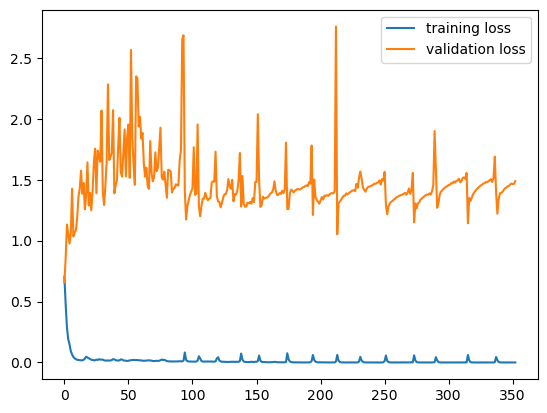

13
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7414 loss_val: 0.6703 time: 36.1805s
 Epoch: 0001 loss_train: 0.5176 loss_val: 0.7760 time: 35.6841s
 Epoch: 0002 loss_train: 0.2971 loss_val: 1.3196 time: 33.7857s
 Epoch: 0003 loss_train: 0.1894 loss_val: 1.4172 time: 33.8973s
 Epoch: 0004 loss_train: 0.1510 loss_val: 1.0322 time: 35.8809s
 Epoch: 0005 loss_train: 0.0848 loss_val: 1.2536 time: 33.3767s
 Epoch: 0006 loss_train: 0.0603 loss_val: 1.1120 time: 34.6498s
 Epoch: 0007 loss_train: 0.0329 loss_val: 1.0467 time: 34.2292s
 Epoch: 0008 loss_train: 0.0152 loss_val: 0.9657 time: 34.5674s
 Epoch: 0009 loss_train: 0.0069 loss_val: 1.0230 time: 34.1503s
 Epoch: 0010 loss_train: 0.0023 loss_val: 1.0069 time: 33.2298s
 Epoch: 0011 loss_train: 0.0008 loss_val: 1.0060 time: 33.3857s
 Epoch: 0012 loss_train: 0.0005 loss_val: 1.0123 time: 34.5806s
 Epoch: 0013 loss_train: 0.0004 loss_val: 1.0189 time: 34.1183s
 Epoch: 0014 loss_train: 0.0004 loss_val: 1.0253 time: 35.2764s
 Epoch: 0015 loss_train: 0.0003 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 1.5260 time: 36.0030s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5307 time: 36.0462s
 Epoch: 0131 loss_train: 0.0000 loss_val: 1.5351 time: 34.9620s
 Epoch: 0132 loss_train: 0.0000 loss_val: 1.5397 time: 34.2692s
 Epoch: 0133 loss_train: 0.0000 loss_val: 1.5444 time: 33.0891s
 Epoch: 0134 loss_train: 0.0000 loss_val: 1.5487 time: 32.6791s
 Epoch: 0135 loss_train: 0.0000 loss_val: 1.5530 time: 31.9583s
 Epoch: 0136 loss_train: 0.0000 loss_val: 1.5575 time: 34.3485s
 Epoch: 0137 loss_train: 0.0000 loss_val: 1.5619 time: 35.3295s
 Epoch: 0138 loss_train: 0.0000 loss_val: 1.5664 time: 34.8983s
 Epoch: 0139 loss_train: 0.0000 loss_val: 1.5710 time: 35.4495s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5753 time: 35.6650s
 Epoch: 0141 loss_train: 0.0000 loss_val: 1.5797 time: 33.9026s
 Epoch: 0142 loss_train: 0.0000 loss_val: 1.5840 time: 32.9060s
 Epoch: 0143 loss_train: 0.0000 loss_val: 1.5885 time: 31.4290s
 Epoch: 0144 loss_train: 0.0000 loss_val

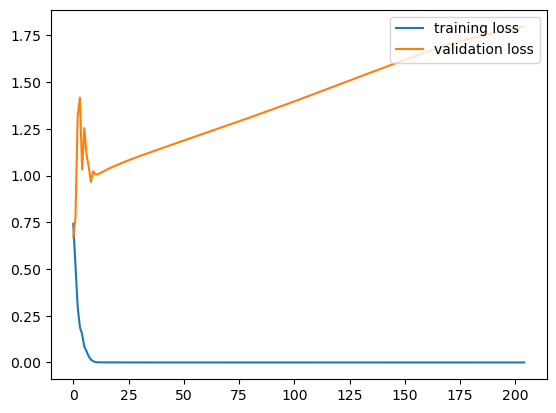

14
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7906 loss_val: 0.7884 time: 36.8815s
 Epoch: 0001 loss_train: 0.5712 loss_val: 0.7504 time: 35.3641s
 Epoch: 0002 loss_train: 0.3668 loss_val: 2.2801 time: 33.7967s
 Epoch: 0003 loss_train: 0.2286 loss_val: 2.7074 time: 35.6184s
 Epoch: 0004 loss_train: 0.2196 loss_val: 1.0358 time: 36.4999s
 Epoch: 0005 loss_train: 0.1415 loss_val: 1.0343 time: 36.4820s
 Epoch: 0006 loss_train: 0.0906 loss_val: 1.5610 time: 35.7065s
 Epoch: 0007 loss_train: 0.0695 loss_val: 1.6846 time: 34.4521s
 Epoch: 0008 loss_train: 0.0586 loss_val: 1.4353 time: 34.8865s
 Epoch: 0009 loss_train: 0.0499 loss_val: 1.5497 time: 35.4593s
 Epoch: 0010 loss_train: 0.0451 loss_val: 1.7232 time: 35.0287s
 Epoch: 0011 loss_train: 0.0376 loss_val: 2.1207 time: 32.5095s
 Epoch: 0012 loss_train: 0.0306 loss_val: 1.4199 time: 35.2767s
 Epoch: 0013 loss_train: 0.0247 loss_val: 1.3989 time: 35.8551s
 Epoch: 0014 loss_train: 0.0220 loss_val: 1.5208 time: 35.3298s
 Epoch: 0015 loss_train: 0.0184 loss_val

 Epoch: 0129 loss_train: 0.0107 loss_val: 1.9593 time: 26.5634s
 Epoch: 0130 loss_train: 0.0094 loss_val: 1.9300 time: 25.7800s
 Epoch: 0131 loss_train: 0.0090 loss_val: 1.9834 time: 28.2615s
 Epoch: 0132 loss_train: 0.0084 loss_val: 2.0062 time: 28.8242s
 Epoch: 0133 loss_train: 0.0081 loss_val: 1.9194 time: 29.7197s
 Epoch: 0134 loss_train: 0.0082 loss_val: 2.0842 time: 29.1346s
 Epoch: 0135 loss_train: 0.0092 loss_val: 1.9607 time: 27.5167s
 Epoch: 0136 loss_train: 0.0087 loss_val: 2.1171 time: 27.7545s
 Epoch: 0137 loss_train: 0.0085 loss_val: 2.1730 time: 29.0555s
 Epoch: 0138 loss_train: 0.0077 loss_val: 2.1891 time: 28.8155s
 Epoch: 0139 loss_train: 0.0096 loss_val: 2.2060 time: 28.2987s
 Epoch: 0140 loss_train: 0.0203 loss_val: 2.4795 time: 28.5636s
 Epoch: 0141 loss_train: 0.0693 loss_val: 1.5367 time: 27.6908s
 Epoch: 0142 loss_train: 0.0216 loss_val: 1.6113 time: 29.9574s
 Epoch: 0143 loss_train: 0.0108 loss_val: 1.6392 time: 30.1005s
 Epoch: 0144 loss_train: 0.0085 loss_val

 Epoch: 0258 loss_train: 0.0044 loss_val: 1.7309 time: 28.0206s
 Epoch: 0259 loss_train: 0.0049 loss_val: 1.7133 time: 27.1784s
 Epoch: 0260 loss_train: 0.0049 loss_val: 1.7385 time: 26.3579s
 Epoch: 0261 loss_train: 0.0044 loss_val: 1.7762 time: 27.3367s
 Epoch: 0262 loss_train: 0.0042 loss_val: 1.8020 time: 27.5623s
 Epoch: 0263 loss_train: 0.0038 loss_val: 1.8030 time: 28.6014s
 Epoch: 0264 loss_train: 0.0035 loss_val: 1.7878 time: 24.9484s
 Epoch: 0265 loss_train: 0.0030 loss_val: 1.8070 time: 28.5053s
 Epoch: 0266 loss_train: 0.0030 loss_val: 1.7897 time: 28.2119s
 Epoch: 0267 loss_train: 0.0029 loss_val: 1.7572 time: 29.5473s
 Epoch: 0268 loss_train: 0.0030 loss_val: 1.8572 time: 28.3144s
 Epoch: 0269 loss_train: 0.0033 loss_val: 1.9156 time: 27.2586s
 Epoch: 0270 loss_train: 0.0029 loss_val: 1.8640 time: 27.1924s
 Epoch: 0271 loss_train: 0.0034 loss_val: 2.0530 time: 29.2140s
 Epoch: 0272 loss_train: 0.0035 loss_val: 1.9685 time: 27.9186s
 Epoch: 0273 loss_train: 0.0037 loss_val

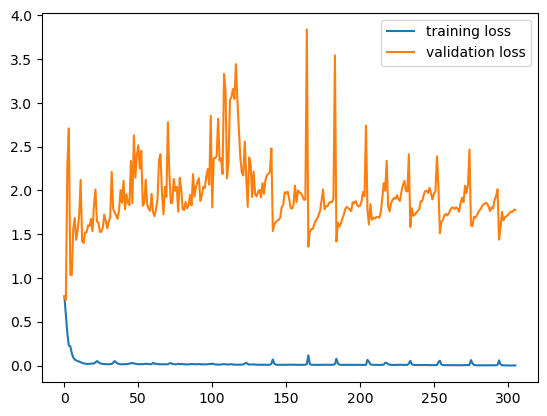

15
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7445 loss_val: 0.6250 time: 24.2359s
 Epoch: 0001 loss_train: 0.4962 loss_val: 0.8129 time: 24.2103s
 Epoch: 0002 loss_train: 0.3072 loss_val: 0.9419 time: 22.9733s
 Epoch: 0003 loss_train: 0.1936 loss_val: 1.4639 time: 28.4960s
 Epoch: 0004 loss_train: 0.1871 loss_val: 2.0241 time: 26.2643s
 Epoch: 0005 loss_train: 0.1418 loss_val: 1.5632 time: 28.3421s
 Epoch: 0006 loss_train: 0.0807 loss_val: 1.2968 time: 24.7998s
 Epoch: 0007 loss_train: 0.0536 loss_val: 1.2704 time: 22.8630s
 Epoch: 0008 loss_train: 0.0389 loss_val: 1.3267 time: 25.4916s
 Epoch: 0009 loss_train: 0.0287 loss_val: 1.0302 time: 24.2608s
 Epoch: 0010 loss_train: 0.0228 loss_val: 1.0256 time: 27.6403s
 Epoch: 0011 loss_train: 0.0197 loss_val: 1.0556 time: 30.4895s
 Epoch: 0012 loss_train: 0.0191 loss_val: 1.1217 time: 28.7132s
 Epoch: 0013 loss_train: 0.0178 loss_val: 1.2635 time: 28.3754s
 Epoch: 0014 loss_train: 0.0211 loss_val: 1.2777 time: 27.8524s
 Epoch: 0015 loss_train: 0.0204 loss_val

 Epoch: 0129 loss_train: 0.0072 loss_val: 1.6142 time: 27.2823s
 Epoch: 0130 loss_train: 0.0072 loss_val: 1.5750 time: 22.7805s
 Epoch: 0131 loss_train: 0.0076 loss_val: 1.5730 time: 25.5662s
 Epoch: 0132 loss_train: 0.0144 loss_val: 1.5355 time: 25.3090s
 Epoch: 0133 loss_train: 0.0359 loss_val: 1.7007 time: 29.5260s
 Epoch: 0134 loss_train: 0.0306 loss_val: 1.4017 time: 28.2619s
 Epoch: 0135 loss_train: 0.0171 loss_val: 1.4941 time: 25.5662s
 Epoch: 0136 loss_train: 0.0110 loss_val: 1.9775 time: 28.3484s
 Epoch: 0137 loss_train: 0.0080 loss_val: 1.5050 time: 27.1172s
 Epoch: 0138 loss_train: 0.0074 loss_val: 1.4755 time: 28.5568s
 Epoch: 0139 loss_train: 0.0071 loss_val: 1.5585 time: 25.8221s
 Epoch: 0140 loss_train: 0.0082 loss_val: 1.5446 time: 23.6566s
 Epoch: 0141 loss_train: 0.0089 loss_val: 1.5194 time: 25.4260s
 Epoch: 0142 loss_train: 0.0082 loss_val: 1.5347 time: 25.7004s
 Epoch: 0143 loss_train: 0.0073 loss_val: 1.4913 time: 25.4408s
 Epoch: 0144 loss_train: 0.0069 loss_val

 Epoch: 0258 loss_train: 0.0002 loss_val: 1.5212 time: 26.0942s
 Epoch: 0259 loss_train: 0.0003 loss_val: 1.5242 time: 26.3133s
 Epoch: 0260 loss_train: 0.0002 loss_val: 1.5256 time: 27.6695s
 Epoch: 0261 loss_train: 0.0004 loss_val: 1.5409 time: 26.9727s
 Epoch: 0262 loss_train: 0.0007 loss_val: 1.5082 time: 27.6890s
 Epoch: 0263 loss_train: 0.0026 loss_val: 1.4530 time: 27.9119s
 Epoch: 0264 loss_train: 0.0040 loss_val: 1.5865 time: 26.8513s
 Epoch: 0265 loss_train: 0.0029 loss_val: 1.4906 time: 25.7874s
 Epoch: 0266 loss_train: 0.0033 loss_val: 1.5262 time: 27.0581s
 Epoch: 0267 loss_train: 0.0024 loss_val: 1.6384 time: 27.2220s
 Epoch: 0268 loss_train: 0.0015 loss_val: 1.5475 time: 25.9093s
 Epoch: 0269 loss_train: 0.0011 loss_val: 1.5607 time: 27.5863s
 Epoch: 0270 loss_train: 0.0010 loss_val: 1.6025 time: 22.5208s
 Epoch: 0271 loss_train: 0.0017 loss_val: 1.7165 time: 26.5925s
 Epoch: 0272 loss_train: 0.0022 loss_val: 1.6368 time: 25.7097s
 Epoch: 0273 loss_train: 0.0028 loss_val

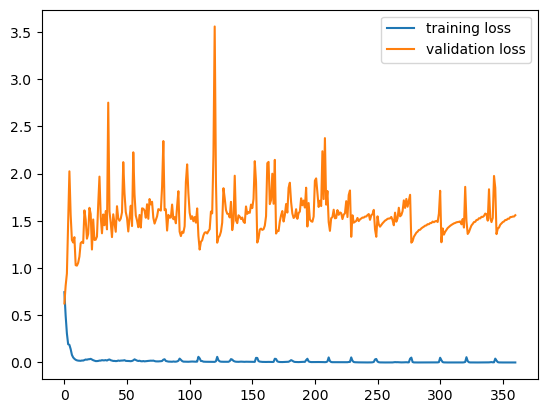

16
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7681 loss_val: 0.7926 time: 27.9276s
 Epoch: 0001 loss_train: 0.5231 loss_val: 0.5906 time: 27.2116s
 Epoch: 0002 loss_train: 0.3097 loss_val: 0.7416 time: 25.2425s
 Epoch: 0003 loss_train: 0.1935 loss_val: 0.9248 time: 27.0270s
 Epoch: 0004 loss_train: 0.1623 loss_val: 1.1528 time: 25.4611s
 Epoch: 0005 loss_train: 0.1236 loss_val: 1.6034 time: 27.0645s
 Epoch: 0006 loss_train: 0.0947 loss_val: 1.3316 time: 25.2097s
 Epoch: 0007 loss_train: 0.0634 loss_val: 1.4146 time: 26.7678s
 Epoch: 0008 loss_train: 0.0544 loss_val: 0.9780 time: 27.2998s
 Epoch: 0009 loss_train: 0.0403 loss_val: 1.0888 time: 29.2352s
 Epoch: 0010 loss_train: 0.0341 loss_val: 1.1244 time: 25.2943s
 Epoch: 0011 loss_train: 0.0285 loss_val: 1.5626 time: 25.2330s
 Epoch: 0012 loss_train: 0.0309 loss_val: 1.1243 time: 27.3565s
 Epoch: 0013 loss_train: 0.0298 loss_val: 1.2136 time: 27.0195s
 Epoch: 0014 loss_train: 0.0288 loss_val: 1.4219 time: 27.5894s
 Epoch: 0015 loss_train: 0.0264 loss_val

 Epoch: 0129 loss_train: 0.0089 loss_val: 1.5473 time: 26.9205s
 Epoch: 0130 loss_train: 0.0079 loss_val: 1.6117 time: 28.6215s
 Epoch: 0131 loss_train: 0.0088 loss_val: 1.4360 time: 24.9224s
 Epoch: 0132 loss_train: 0.0094 loss_val: 2.2660 time: 25.3968s
 Epoch: 0133 loss_train: 0.0455 loss_val: 1.4606 time: 27.0758s
 Epoch: 0134 loss_train: 0.0420 loss_val: 1.3874 time: 24.6458s
 Epoch: 0135 loss_train: 0.0147 loss_val: 1.2855 time: 24.6990s
 Epoch: 0136 loss_train: 0.0093 loss_val: 1.3728 time: 24.7906s
 Epoch: 0137 loss_train: 0.0072 loss_val: 1.3767 time: 28.0494s
 Epoch: 0138 loss_train: 0.0066 loss_val: 1.3957 time: 25.7781s
 Epoch: 0139 loss_train: 0.0063 loss_val: 1.4009 time: 29.4653s
 Epoch: 0140 loss_train: 0.0068 loss_val: 1.5618 time: 25.7748s
 Epoch: 0141 loss_train: 0.0064 loss_val: 1.5694 time: 27.6727s
 Epoch: 0142 loss_train: 0.0081 loss_val: 1.5849 time: 26.8008s
 Epoch: 0143 loss_train: 0.0086 loss_val: 1.7710 time: 27.0870s
 Epoch: 0144 loss_train: 0.0076 loss_val

 Epoch: 0258 loss_train: 0.0010 loss_val: 1.3261 time: 28.0963s
 Epoch: 0259 loss_train: 0.0012 loss_val: 1.3759 time: 27.0639s
 Epoch: 0260 loss_train: 0.0009 loss_val: 1.3840 time: 26.3624s
 Epoch: 0261 loss_train: 0.0023 loss_val: 1.3920 time: 28.7263s
 Epoch: 0262 loss_train: 0.0021 loss_val: 1.3978 time: 26.3075s
 Epoch: 0263 loss_train: 0.0022 loss_val: 1.3582 time: 27.9877s
 Epoch: 0264 loss_train: 0.0010 loss_val: 1.4043 time: 27.4776s
 Epoch: 0265 loss_train: 0.0009 loss_val: 1.3604 time: 28.2236s
 Epoch: 0266 loss_train: 0.0005 loss_val: 1.3673 time: 26.4519s
 Epoch: 0267 loss_train: 0.0004 loss_val: 1.3865 time: 28.0310s
 Epoch: 0268 loss_train: 0.0005 loss_val: 1.4046 time: 25.0320s
 Epoch: 0269 loss_train: 0.0010 loss_val: 1.4659 time: 25.9290s
 Epoch: 0270 loss_train: 0.0040 loss_val: 1.3256 time: 28.8546s
 Epoch: 0271 loss_train: 0.0033 loss_val: 1.3539 time: 25.9482s
 Epoch: 0272 loss_train: 0.0020 loss_val: 1.4018 time: 28.7532s
 Epoch: 0273 loss_train: 0.0241 loss_val

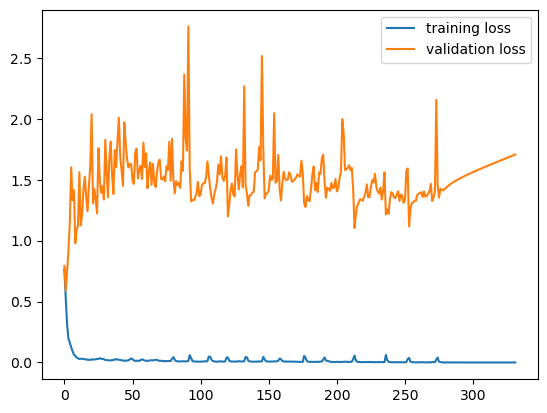

17
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7701 loss_val: 0.7326 time: 29.3308s
 Epoch: 0001 loss_train: 0.5422 loss_val: 0.8528 time: 24.8232s
 Epoch: 0002 loss_train: 0.3440 loss_val: 0.9435 time: 25.9125s
 Epoch: 0003 loss_train: 0.2009 loss_val: 1.0580 time: 27.3325s
 Epoch: 0004 loss_train: 0.1838 loss_val: 1.5438 time: 27.3516s
 Epoch: 0005 loss_train: 0.1181 loss_val: 1.3200 time: 25.8843s
 Epoch: 0006 loss_train: 0.0921 loss_val: 1.1748 time: 25.5285s
 Epoch: 0007 loss_train: 0.0648 loss_val: 1.2781 time: 23.7791s
 Epoch: 0008 loss_train: 0.0477 loss_val: 1.2657 time: 26.7640s
 Epoch: 0009 loss_train: 0.0358 loss_val: 1.5008 time: 25.1955s
 Epoch: 0010 loss_train: 0.0333 loss_val: 1.2190 time: 25.4481s
 Epoch: 0011 loss_train: 0.0300 loss_val: 1.3223 time: 27.7367s
 Epoch: 0012 loss_train: 0.0276 loss_val: 1.5473 time: 26.6401s
 Epoch: 0013 loss_train: 0.0246 loss_val: 1.3723 time: 25.8900s
 Epoch: 0014 loss_train: 0.0220 loss_val: 1.5746 time: 26.5942s
 Epoch: 0015 loss_train: 0.0209 loss_val

 Epoch: 0129 loss_train: 0.0083 loss_val: 1.6407 time: 21.7481s
 Epoch: 0130 loss_train: 0.0088 loss_val: 1.5954 time: 16.5266s
 Epoch: 0131 loss_train: 0.0096 loss_val: 1.9515 time: 17.2999s
 Epoch: 0132 loss_train: 0.0531 loss_val: 1.9996 time: 16.0398s
 Epoch: 0133 loss_train: 0.0304 loss_val: 1.4618 time: 17.5546s
 Epoch: 0134 loss_train: 0.0184 loss_val: 1.5042 time: 17.3554s
 Epoch: 0135 loss_train: 0.0141 loss_val: 1.5432 time: 19.4287s
 Epoch: 0136 loss_train: 0.0106 loss_val: 1.5834 time: 18.0350s
 Epoch: 0137 loss_train: 0.0085 loss_val: 1.5789 time: 17.2931s
 Epoch: 0138 loss_train: 0.0081 loss_val: 1.6179 time: 18.4889s
 Epoch: 0139 loss_train: 0.0078 loss_val: 1.6683 time: 17.4193s
 Epoch: 0140 loss_train: 0.0077 loss_val: 1.6678 time: 20.3707s
 Epoch: 0141 loss_train: 0.0074 loss_val: 1.6564 time: 17.6442s
 Epoch: 0142 loss_train: 0.0076 loss_val: 1.7098 time: 18.2113s
 Epoch: 0143 loss_train: 0.0093 loss_val: 1.6734 time: 16.2458s
 Epoch: 0144 loss_train: 0.0081 loss_val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Epoch: 0302 loss_train: 0.0005 loss_val: 1.5818 time: 17.3287s
 Epoch: 0303 loss_train: 0.0004 loss_val: 1.5953 time: 16.6621s
 Epoch: 0304 loss_train: 0.0003 loss_val: 1.6129 time: 16.7028s
 Epoch: 0305 loss_train: 0.0002 loss_val: 1.6281 time: 17.0889s
 Epoch: 0306 loss_train: 0.0002 loss_val: 1.6380 time: 16.3804s
 Epoch: 0307 loss_train: 0.0002 loss_val: 1.6490 time: 15.9327s
 Epoch: 0308 loss_train: 0.0001 loss_val: 1.6578 time: 17.1098s
 Epoch: 0309 loss_train: 0.0001 loss_val: 1.6671 time: 17.3330s
 Epoch: 0310 loss_train: 0.0001 loss_val: 1.6746 time: 19.1871s
 Epoch: 0311 loss_train: 0.0001 loss_val: 1.6831 time: 18.6373s
 Epoch: 0312 loss_train: 0.0001 loss_val: 1.6894 time: 17.1868s
 Epoch: 0313 loss_train: 0.0001 loss_val: 1.6977 time: 16.9064s
 Epoch: 0314 loss_train: 0.0001 loss_val: 1.7018 time: 16.5225s
 Epoch: 0315 loss_train: 0.0001 loss_val: 1.7111 time: 16.2047s
 Epoch: 0316 loss_train: 0.0001 loss_val: 1.7136 time: 16.3387s
 Epoch: 0317 loss_train: 0.0001 loss_val

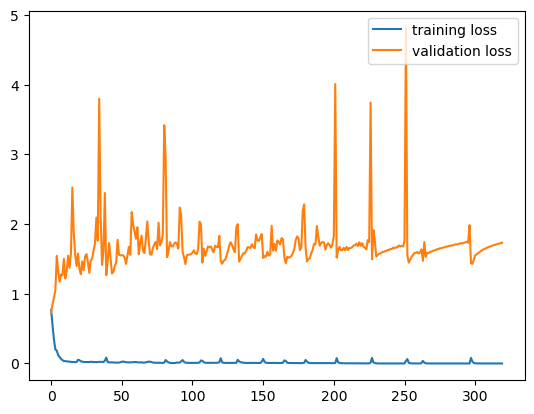

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7001 loss_val: 0.6744 time: 16.8908s
 Epoch: 0001 loss_train: 0.4642 loss_val: 0.7295 time: 16.8134s
 Epoch: 0002 loss_train: 0.2659 loss_val: 1.0564 time: 16.2910s
 Epoch: 0003 loss_train: 0.1747 loss_val: 0.9876 time: 18.7916s
 Epoch: 0004 loss_train: 0.1457 loss_val: 1.6423 time: 16.6306s
 Epoch: 0005 loss_train: 0.1081 loss_val: 0.9697 time: 15.7465s
 Epoch: 0006 loss_train: 0.0554 loss_val: 0.9166 time: 15.4030s
 Epoch: 0007 loss_train: 0.0338 loss_val: 1.2381 time: 16.2025s
 Epoch: 0008 loss_train: 0.0260 loss_val: 1.0861 time: 16.9385s
 Epoch: 0009 loss_train: 0.0198 loss_val: 1.0680 time: 18.2725s
 Epoch: 0010 loss_train: 0.0164 loss_val: 1.1888 time: 16.8018s
 Epoch: 0011 loss_train: 0.0141 loss_val: 1.1675 time: 15.1582s
 Epoch: 0012 loss_train: 0.0124 loss_val: 1.3043 time: 16.6427s
 Epoch: 0013 loss_train: 0.0120 loss_val: 1.2259 time: 15.7972s
 Epoch: 0014 loss_train: 0.0115 loss_val: 1.3755 time: 17.7192s
 Epoch: 0015 loss_train: 0.0118 loss_val

 Epoch: 0129 loss_train: 0.0616 loss_val: 1.3147 time: 15.7532s
 Epoch: 0130 loss_train: 0.0390 loss_val: 1.7668 time: 14.8719s
 Epoch: 0131 loss_train: 0.0116 loss_val: 1.3676 time: 16.1010s
 Epoch: 0132 loss_train: 0.0075 loss_val: 1.3995 time: 15.6505s
 Epoch: 0133 loss_train: 0.0069 loss_val: 1.4478 time: 16.3419s
 Epoch: 0134 loss_train: 0.0071 loss_val: 1.4155 time: 16.8203s
 Epoch: 0135 loss_train: 0.0068 loss_val: 1.6341 time: 15.8764s
 Epoch: 0136 loss_train: 0.0064 loss_val: 1.5471 time: 13.8841s
 Epoch: 0137 loss_train: 0.0072 loss_val: 1.5634 time: 14.4621s
 Epoch: 0138 loss_train: 0.0077 loss_val: 1.6133 time: 14.0255s
 Epoch: 0139 loss_train: 0.0082 loss_val: 1.6105 time: 13.6771s
 Epoch: 0140 loss_train: 0.0080 loss_val: 1.5677 time: 14.4420s
 Epoch: 0141 loss_train: 0.0070 loss_val: 1.5097 time: 14.9515s
 Epoch: 0142 loss_train: 0.0099 loss_val: 1.8808 time: 14.7898s
 Epoch: 0143 loss_train: 0.0421 loss_val: 2.3614 time: 15.7641s
 Epoch: 0144 loss_train: 0.0334 loss_val

 Epoch: 0266 loss_train: 0.0020 loss_val: 1.4364 time: 14.0688s
 Epoch: 0267 loss_train: 0.0015 loss_val: 1.4937 time: 14.8775s
 Epoch: 0268 loss_train: 0.0015 loss_val: 1.5407 time: 12.6018s
 Epoch: 0269 loss_train: 0.0015 loss_val: 1.4976 time: 14.4175s
 Epoch: 0270 loss_train: 0.0020 loss_val: 1.5055 time: 13.5509s
 Epoch: 0271 loss_train: 0.0022 loss_val: 1.4913 time: 13.1530s
 Epoch: 0272 loss_train: 0.0010 loss_val: 1.5374 time: 14.0621s
 Epoch: 0273 loss_train: 0.0005 loss_val: 1.5535 time: 13.7922s
 Epoch: 0274 loss_train: 0.0003 loss_val: 1.5549 time: 16.9491s
 Epoch: 0275 loss_train: 0.0002 loss_val: 1.5629 time: 15.4842s
 Epoch: 0276 loss_train: 0.0002 loss_val: 1.5765 time: 14.9688s
 Epoch: 0277 loss_train: 0.0002 loss_val: 1.5853 time: 13.7201s
 Epoch: 0278 loss_train: 0.0002 loss_val: 1.5913 time: 13.1334s
 Epoch: 0279 loss_train: 0.0002 loss_val: 1.6033 time: 13.5046s
 Epoch: 0280 loss_train: 0.0001 loss_val: 1.6044 time: 13.4567s
 Epoch: 0281 loss_train: 0.0001 loss_val

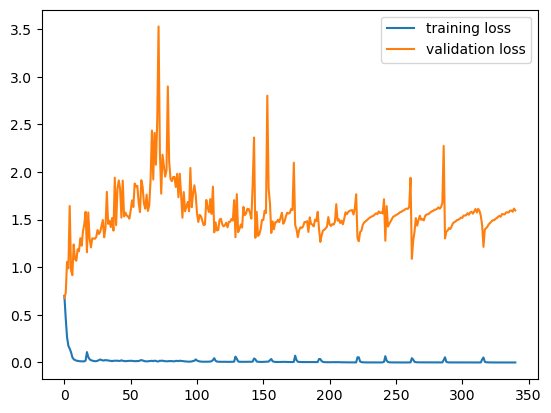

19
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7404 loss_val: 0.9695 time: 15.0105s
 Epoch: 0001 loss_train: 0.5109 loss_val: 0.6874 time: 12.9424s
 Epoch: 0002 loss_train: 0.2960 loss_val: 1.5658 time: 15.1815s
 Epoch: 0003 loss_train: 0.1829 loss_val: 1.7716 time: 15.2230s
 Epoch: 0004 loss_train: 0.1678 loss_val: 1.2284 time: 13.9727s
 Epoch: 0005 loss_train: 0.0976 loss_val: 1.1683 time: 14.8901s
 Epoch: 0006 loss_train: 0.0604 loss_val: 1.2448 time: 13.6794s
 Epoch: 0007 loss_train: 0.0235 loss_val: 1.0925 time: 14.4871s
 Epoch: 0008 loss_train: 0.0095 loss_val: 1.0437 time: 13.6309s
 Epoch: 0009 loss_train: 0.0032 loss_val: 1.0071 time: 15.3035s
 Epoch: 0010 loss_train: 0.0010 loss_val: 1.0119 time: 14.9729s
 Epoch: 0011 loss_train: 0.0006 loss_val: 1.0209 time: 14.7861s
 Epoch: 0012 loss_train: 0.0005 loss_val: 1.0288 time: 15.3887s
 Epoch: 0013 loss_train: 0.0005 loss_val: 1.0362 time: 14.0916s
 Epoch: 0014 loss_train: 0.0004 loss_val: 1.0432 time: 16.0072s
 Epoch: 0015 loss_train: 0.0004 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 1.5809 time: 15.0579s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5856 time: 13.8151s
 Epoch: 0131 loss_train: 0.0000 loss_val: 1.5905 time: 15.5606s
 Epoch: 0132 loss_train: 0.0000 loss_val: 1.5949 time: 16.6597s
 Epoch: 0133 loss_train: 0.0000 loss_val: 1.5998 time: 14.2341s
 Epoch: 0134 loss_train: 0.0000 loss_val: 1.6046 time: 15.3913s
 Epoch: 0135 loss_train: 0.0000 loss_val: 1.6094 time: 14.9542s
 Epoch: 0136 loss_train: 0.0000 loss_val: 1.6140 time: 14.8894s
 Epoch: 0137 loss_train: 0.0000 loss_val: 1.6185 time: 14.4371s
 Epoch: 0138 loss_train: 0.0000 loss_val: 1.6233 time: 14.2787s
 Epoch: 0139 loss_train: 0.0000 loss_val: 1.6279 time: 14.0522s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.6324 time: 14.3711s
 Epoch: 0141 loss_train: 0.0000 loss_val: 1.6369 time: 13.5840s
 Epoch: 0142 loss_train: 0.0000 loss_val: 1.6415 time: 13.5653s
 Epoch: 0143 loss_train: 0.0000 loss_val: 1.6461 time: 15.7343s
 Epoch: 0144 loss_train: 0.0000 loss_val

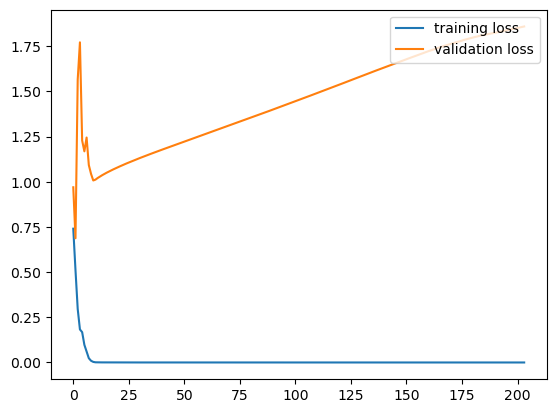

20
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7880 loss_val: 0.7192 time: 16.2208s
 Epoch: 0001 loss_train: 0.5693 loss_val: 0.6777 time: 13.3437s
 Epoch: 0002 loss_train: 0.3615 loss_val: 1.4045 time: 16.1493s
 Epoch: 0003 loss_train: 0.2325 loss_val: 1.2389 time: 13.4355s
 Epoch: 0004 loss_train: 0.2042 loss_val: 1.3586 time: 13.9988s
 Epoch: 0005 loss_train: 0.1435 loss_val: 1.1253 time: 14.0673s
 Epoch: 0006 loss_train: 0.1024 loss_val: 1.3034 time: 14.6005s
 Epoch: 0007 loss_train: 0.0834 loss_val: 1.5775 time: 14.0010s
 Epoch: 0008 loss_train: 0.0574 loss_val: 1.9173 time: 14.6356s
 Epoch: 0009 loss_train: 0.0411 loss_val: 1.9614 time: 14.2244s
 Epoch: 0010 loss_train: 0.0361 loss_val: 1.6111 time: 13.8183s
 Epoch: 0011 loss_train: 0.0332 loss_val: 1.1493 time: 13.3345s
 Epoch: 0012 loss_train: 0.0234 loss_val: 1.2497 time: 14.2549s
 Epoch: 0013 loss_train: 0.0206 loss_val: 1.4167 time: 14.9835s
 Epoch: 0014 loss_train: 0.0204 loss_val: 1.6291 time: 14.2768s
 Epoch: 0015 loss_train: 0.0201 loss_val

 Epoch: 0129 loss_train: 0.0087 loss_val: 1.8430 time: 13.8576s
 Epoch: 0130 loss_train: 0.0105 loss_val: 1.8078 time: 13.9230s
 Epoch: 0131 loss_train: 0.0089 loss_val: 2.0027 time: 13.4405s
 Epoch: 0132 loss_train: 0.0079 loss_val: 2.0217 time: 13.9999s
 Epoch: 0133 loss_train: 0.0077 loss_val: 1.9329 time: 13.7841s
 Epoch: 0134 loss_train: 0.0084 loss_val: 2.5516 time: 14.6271s
 Epoch: 0135 loss_train: 0.0074 loss_val: 2.1939 time: 14.1074s
 Epoch: 0136 loss_train: 0.0096 loss_val: 1.9952 time: 14.7227s
 Epoch: 0137 loss_train: 0.0206 loss_val: 1.9998 time: 17.9839s
 Epoch: 0138 loss_train: 0.0356 loss_val: 2.2966 time: 14.5690s
 Epoch: 0139 loss_train: 0.0205 loss_val: 1.8300 time: 16.3372s
 Epoch: 0140 loss_train: 0.0107 loss_val: 1.7584 time: 14.6971s
 Epoch: 0141 loss_train: 0.0081 loss_val: 1.9352 time: 14.1360s
 Epoch: 0142 loss_train: 0.0065 loss_val: 2.2208 time: 14.2213s
 Epoch: 0143 loss_train: 0.0063 loss_val: 2.4522 time: 15.3820s
 Epoch: 0144 loss_train: 0.0069 loss_val

 Epoch: 0258 loss_train: 0.0021 loss_val: 1.7166 time: 13.4907s
 Epoch: 0259 loss_train: 0.0022 loss_val: 1.7383 time: 15.5756s
 Epoch: 0260 loss_train: 0.0023 loss_val: 1.7401 time: 13.6332s
 Epoch: 0261 loss_train: 0.0028 loss_val: 1.7427 time: 14.5735s
 Epoch: 0262 loss_train: 0.0026 loss_val: 1.7835 time: 13.7695s
 Epoch: 0263 loss_train: 0.0025 loss_val: 1.7738 time: 15.5654s
 Epoch: 0264 loss_train: 0.0020 loss_val: 1.7561 time: 13.2975s
 Epoch: 0265 loss_train: 0.0025 loss_val: 1.7672 time: 13.2893s
 Epoch: 0266 loss_train: 0.0709 loss_val: 1.3024 time: 14.8372s
 Epoch: 0267 loss_train: 0.0258 loss_val: 1.5534 time: 15.3573s
 Epoch: 0268 loss_train: 0.0052 loss_val: 1.7389 time: 18.0933s
 Epoch: 0269 loss_train: 0.0027 loss_val: 1.5637 time: 17.7219s
 Epoch: 0270 loss_train: 0.0032 loss_val: 1.5449 time: 17.2373s
 Epoch: 0271 loss_train: 0.0021 loss_val: 1.6008 time: 14.5428s
 Epoch: 0272 loss_train: 0.0016 loss_val: 1.6180 time: 14.4290s
 Epoch: 0273 loss_train: 0.0014 loss_val

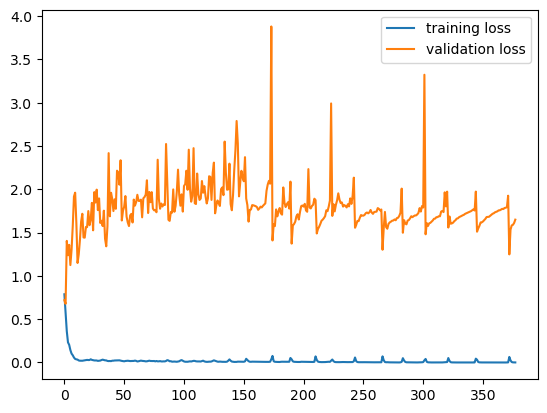

21
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7435 loss_val: 0.8156 time: 16.2225s
 Epoch: 0001 loss_train: 0.4989 loss_val: 0.6873 time: 14.0985s
 Epoch: 0002 loss_train: 0.3164 loss_val: 0.9725 time: 15.0739s
 Epoch: 0003 loss_train: 0.1880 loss_val: 1.0362 time: 13.7970s
 Epoch: 0004 loss_train: 0.1779 loss_val: 1.8787 time: 15.1099s
 Epoch: 0005 loss_train: 0.1253 loss_val: 1.4610 time: 15.3266s
 Epoch: 0006 loss_train: 0.1053 loss_val: 1.1633 time: 14.6256s
 Epoch: 0007 loss_train: 0.0757 loss_val: 0.9837 time: 15.3989s
 Epoch: 0008 loss_train: 0.0466 loss_val: 1.1178 time: 14.3079s
 Epoch: 0009 loss_train: 0.0353 loss_val: 1.1937 time: 13.7266s
 Epoch: 0010 loss_train: 0.0283 loss_val: 1.2340 time: 14.2770s
 Epoch: 0011 loss_train: 0.0235 loss_val: 1.2067 time: 19.5746s
 Epoch: 0012 loss_train: 0.0167 loss_val: 1.1817 time: 14.2066s
 Epoch: 0013 loss_train: 0.0153 loss_val: 1.7866 time: 14.6677s
 Epoch: 0014 loss_train: 0.0148 loss_val: 1.2373 time: 14.5854s
 Epoch: 0015 loss_train: 0.0157 loss_val

 Epoch: 0137 loss_train: 0.0065 loss_val: 1.7495 time: 14.7048s
 Epoch: 0138 loss_train: 0.0097 loss_val: 1.8385 time: 13.9326s
 Epoch: 0139 loss_train: 0.0686 loss_val: 1.2498 time: 14.0355s
 Epoch: 0140 loss_train: 0.0238 loss_val: 1.2259 time: 13.2892s
 Epoch: 0141 loss_train: 0.0098 loss_val: 1.3348 time: 14.5628s
 Epoch: 0142 loss_train: 0.0071 loss_val: 1.3791 time: 13.6767s
 Epoch: 0143 loss_train: 0.0068 loss_val: 1.4302 time: 15.2177s
 Epoch: 0144 loss_train: 0.0067 loss_val: 1.3919 time: 14.6275s
 Epoch: 0145 loss_train: 0.0063 loss_val: 1.3877 time: 16.2475s
 Epoch: 0146 loss_train: 0.0066 loss_val: 1.3330 time: 15.7573s
 Epoch: 0147 loss_train: 0.0074 loss_val: 1.3320 time: 13.9329s
 Epoch: 0148 loss_train: 0.0069 loss_val: 1.4556 time: 16.6536s
 Epoch: 0149 loss_train: 0.0067 loss_val: 1.9335 time: 13.8598s
 Epoch: 0150 loss_train: 0.0059 loss_val: 1.4793 time: 14.2566s
 Epoch: 0151 loss_train: 0.0063 loss_val: 1.4290 time: 14.8120s
 Epoch: 0152 loss_train: 0.0059 loss_val

 Epoch: 0266 loss_train: 0.0643 loss_val: 1.2017 time: 14.7661s
 Epoch: 0267 loss_train: 0.0173 loss_val: 1.2877 time: 14.2744s
 Epoch: 0268 loss_train: 0.0042 loss_val: 1.2914 time: 13.3535s
 Epoch: 0269 loss_train: 0.0012 loss_val: 1.3364 time: 14.4892s
 Epoch: 0270 loss_train: 0.0007 loss_val: 1.3449 time: 13.9415s
 Epoch: 0271 loss_train: 0.0005 loss_val: 1.3641 time: 13.1921s
 Epoch: 0272 loss_train: 0.0004 loss_val: 1.3808 time: 14.0179s
 Epoch: 0273 loss_train: 0.0003 loss_val: 1.3932 time: 14.0239s
 Epoch: 0274 loss_train: 0.0003 loss_val: 1.3994 time: 13.4839s
 Epoch: 0275 loss_train: 0.0002 loss_val: 1.4103 time: 15.5435s
 Epoch: 0276 loss_train: 0.0002 loss_val: 1.4153 time: 13.6431s
 Epoch: 0277 loss_train: 0.0002 loss_val: 1.4258 time: 13.9175s
 Epoch: 0278 loss_train: 0.0002 loss_val: 1.4289 time: 13.9765s
 Epoch: 0279 loss_train: 0.0002 loss_val: 1.4404 time: 14.4545s
 Epoch: 0280 loss_train: 0.0002 loss_val: 1.4398 time: 14.4581s
 Epoch: 0281 loss_train: 0.0002 loss_val

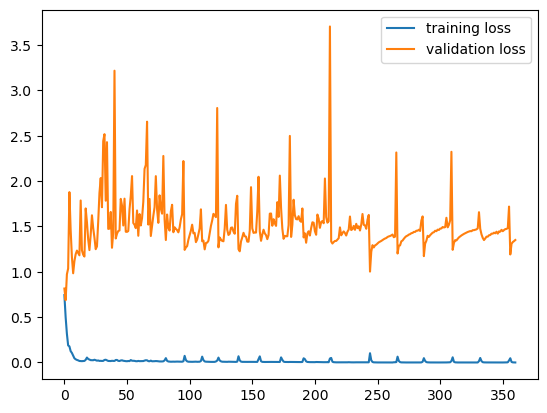

22
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7704 loss_val: 0.7953 time: 15.1585s
 Epoch: 0001 loss_train: 0.5336 loss_val: 0.7777 time: 14.1611s
 Epoch: 0002 loss_train: 0.3414 loss_val: 0.8373 time: 15.5014s
 Epoch: 0003 loss_train: 0.2108 loss_val: 2.4933 time: 14.4732s
 Epoch: 0004 loss_train: 0.1780 loss_val: 1.0669 time: 14.8589s
 Epoch: 0005 loss_train: 0.1167 loss_val: 1.1319 time: 14.6742s
 Epoch: 0006 loss_train: 0.0787 loss_val: 1.5884 time: 15.5304s
 Epoch: 0007 loss_train: 0.0601 loss_val: 1.7035 time: 13.5739s
 Epoch: 0008 loss_train: 0.0491 loss_val: 1.6452 time: 14.6986s
 Epoch: 0009 loss_train: 0.0406 loss_val: 1.2929 time: 14.3153s
 Epoch: 0010 loss_train: 0.0361 loss_val: 1.3076 time: 14.4418s
 Epoch: 0011 loss_train: 0.0334 loss_val: 1.2810 time: 14.4200s
 Epoch: 0012 loss_train: 0.0306 loss_val: 1.8705 time: 14.4362s
 Epoch: 0013 loss_train: 0.0293 loss_val: 2.4248 time: 15.3811s
 Epoch: 0014 loss_train: 0.0279 loss_val: 1.2923 time: 14.1223s
 Epoch: 0015 loss_train: 0.0274 loss_val

 Epoch: 0129 loss_train: 0.0103 loss_val: 2.7147 time: 14.8607s
 Epoch: 0130 loss_train: 0.0113 loss_val: 2.2043 time: 14.7125s
 Epoch: 0131 loss_train: 0.0115 loss_val: 2.0344 time: 14.5524s
 Epoch: 0132 loss_train: 0.0135 loss_val: 2.6276 time: 14.7884s
 Epoch: 0133 loss_train: 0.0104 loss_val: 2.6821 time: 15.5131s
 Epoch: 0134 loss_train: 0.0091 loss_val: 2.9808 time: 14.0689s
 Epoch: 0135 loss_train: 0.0087 loss_val: 3.4845 time: 14.3603s
 Epoch: 0136 loss_train: 0.0094 loss_val: 2.1156 time: 14.5497s
 Epoch: 0137 loss_train: 0.0147 loss_val: 2.5629 time: 13.8469s
 Epoch: 0138 loss_train: 0.0155 loss_val: 2.5650 time: 15.7576s
 Epoch: 0139 loss_train: 0.0130 loss_val: 2.1270 time: 14.8898s
 Epoch: 0140 loss_train: 0.0118 loss_val: 2.5849 time: 14.5286s
 Epoch: 0141 loss_train: 0.0092 loss_val: 3.0621 time: 14.7635s
 Epoch: 0142 loss_train: 0.0135 loss_val: 3.3632 time: 14.5371s
 Epoch: 0143 loss_train: 0.0095 loss_val: 2.5168 time: 14.4381s
 Epoch: 0144 loss_train: 0.0090 loss_val

 Epoch: 0258 loss_train: 0.0022 loss_val: 1.4648 time: 15.4903s
 Epoch: 0259 loss_train: 0.0022 loss_val: 1.4402 time: 14.6956s
 Epoch: 0260 loss_train: 0.0021 loss_val: 1.4831 time: 14.7819s
 Epoch: 0261 loss_train: 0.0024 loss_val: 1.5082 time: 16.0017s
 Epoch: 0262 loss_train: 0.0024 loss_val: 1.5207 time: 16.3786s
 Epoch: 0263 loss_train: 0.0026 loss_val: 1.4400 time: 16.2831s
 Epoch: 0264 loss_train: 0.0020 loss_val: 1.5324 time: 15.2052s
 Epoch: 0265 loss_train: 0.0017 loss_val: 1.4765 time: 15.6229s
 Epoch: 0266 loss_train: 0.0012 loss_val: 1.5034 time: 15.7885s
 Epoch: 0267 loss_train: 0.0016 loss_val: 1.5489 time: 15.0933s
 Epoch: 0268 loss_train: 0.0015 loss_val: 1.5681 time: 15.2173s
 Epoch: 0269 loss_train: 0.0013 loss_val: 1.5974 time: 14.6438s
 Epoch: 0270 loss_train: 0.0441 loss_val: 1.2469 time: 15.4836s
 Epoch: 0271 loss_train: 0.0480 loss_val: 1.2577 time: 15.2455s
 Epoch: 0272 loss_train: 0.0089 loss_val: 1.2974 time: 15.8021s
 Epoch: 0273 loss_train: 0.0031 loss_val

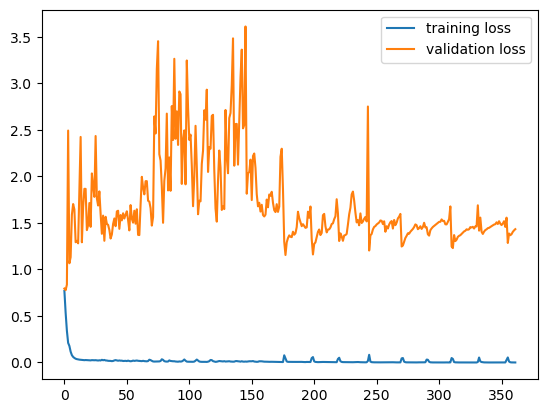

23
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7737 loss_val: 0.8229 time: 16.8447s
 Epoch: 0001 loss_train: 0.5491 loss_val: 0.7718 time: 16.1890s
 Epoch: 0002 loss_train: 0.3543 loss_val: 1.2190 time: 15.8855s
 Epoch: 0003 loss_train: 0.2193 loss_val: 2.1783 time: 15.1066s
 Epoch: 0004 loss_train: 0.2020 loss_val: 1.1167 time: 17.1793s
 Epoch: 0005 loss_train: 0.1309 loss_val: 1.5435 time: 16.0873s
 Epoch: 0006 loss_train: 0.0782 loss_val: 1.2817 time: 16.5145s
 Epoch: 0007 loss_train: 0.0579 loss_val: 1.1592 time: 15.7413s
 Epoch: 0008 loss_train: 0.0419 loss_val: 1.0902 time: 16.9187s
 Epoch: 0009 loss_train: 0.0332 loss_val: 1.6405 time: 16.1011s
 Epoch: 0010 loss_train: 0.0280 loss_val: 1.4975 time: 16.3063s
 Epoch: 0011 loss_train: 0.0251 loss_val: 1.5027 time: 15.0737s
 Epoch: 0012 loss_train: 0.0234 loss_val: 1.3392 time: 16.1493s
 Epoch: 0013 loss_train: 0.0228 loss_val: 1.6359 time: 15.9011s
 Epoch: 0014 loss_train: 0.0246 loss_val: 1.6045 time: 16.0263s
 Epoch: 0015 loss_train: 0.0217 loss_val

 Epoch: 0129 loss_train: 0.0076 loss_val: 1.4807 time: 14.8666s
 Epoch: 0130 loss_train: 0.0071 loss_val: 1.7748 time: 13.8809s
 Epoch: 0131 loss_train: 0.0071 loss_val: 1.5478 time: 15.0509s
 Epoch: 0132 loss_train: 0.0076 loss_val: 1.5152 time: 15.2572s
 Epoch: 0133 loss_train: 0.0077 loss_val: 1.6481 time: 13.9991s
 Epoch: 0134 loss_train: 0.0068 loss_val: 1.6603 time: 14.5350s
 Epoch: 0135 loss_train: 0.0077 loss_val: 1.7570 time: 15.1615s
 Epoch: 0136 loss_train: 0.0096 loss_val: 1.6935 time: 15.0864s
 Epoch: 0137 loss_train: 0.0221 loss_val: 2.8645 time: 14.4948s
 Epoch: 0138 loss_train: 0.0525 loss_val: 1.3673 time: 14.9477s
 Epoch: 0139 loss_train: 0.0214 loss_val: 1.3705 time: 14.3856s
 Epoch: 0140 loss_train: 0.0105 loss_val: 1.5335 time: 14.9171s
 Epoch: 0141 loss_train: 0.0082 loss_val: 1.4441 time: 14.8127s
 Epoch: 0142 loss_train: 0.0075 loss_val: 1.4458 time: 14.9341s
 Epoch: 0143 loss_train: 0.0073 loss_val: 1.4604 time: 15.2643s
 Epoch: 0144 loss_train: 0.0076 loss_val

 Epoch: 0258 loss_train: 0.0003 loss_val: 1.4407 time: 14.8195s
 Epoch: 0259 loss_train: 0.0003 loss_val: 1.4393 time: 15.0004s
 Epoch: 0260 loss_train: 0.0003 loss_val: 1.4676 time: 16.1968s
 Epoch: 0261 loss_train: 0.0004 loss_val: 1.4588 time: 15.4459s
 Epoch: 0262 loss_train: 0.0003 loss_val: 1.4672 time: 15.0373s
 Epoch: 0263 loss_train: 0.0003 loss_val: 1.4565 time: 15.5688s
 Epoch: 0264 loss_train: 0.0002 loss_val: 1.4666 time: 14.8046s
 Epoch: 0265 loss_train: 0.0001 loss_val: 1.4714 time: 15.4520s
 Epoch: 0266 loss_train: 0.0001 loss_val: 1.4790 time: 16.2285s
 Epoch: 0267 loss_train: 0.0001 loss_val: 1.4847 time: 15.6211s
 Epoch: 0268 loss_train: 0.0001 loss_val: 1.4913 time: 14.6171s
 Epoch: 0269 loss_train: 0.0001 loss_val: 1.4959 time: 16.0686s
 Epoch: 0270 loss_train: 0.0001 loss_val: 1.5018 time: 14.5544s
 Epoch: 0271 loss_train: 0.0001 loss_val: 1.5077 time: 16.3915s
 Epoch: 0272 loss_train: 0.0001 loss_val: 1.5089 time: 15.9489s
 Epoch: 0273 loss_train: 0.0014 loss_val

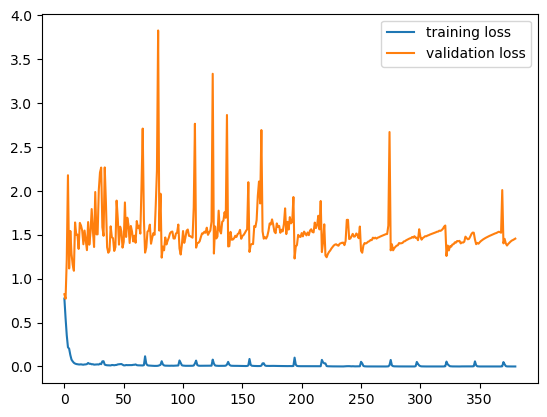

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7012 loss_val: 0.6682 time: 15.4866s
 Epoch: 0001 loss_train: 0.4651 loss_val: 0.6627 time: 16.1165s
 Epoch: 0002 loss_train: 0.2545 loss_val: 1.1916 time: 15.1224s
 Epoch: 0003 loss_train: 0.1656 loss_val: 2.5105 time: 14.6859s
 Epoch: 0004 loss_train: 0.1542 loss_val: 0.9138 time: 14.1531s
 Epoch: 0005 loss_train: 0.0868 loss_val: 1.6440 time: 14.9335s
 Epoch: 0006 loss_train: 0.0580 loss_val: 1.1283 time: 14.5569s
 Epoch: 0007 loss_train: 0.0466 loss_val: 1.3924 time: 14.3219s
 Epoch: 0008 loss_train: 0.0378 loss_val: 1.3128 time: 15.2045s
 Epoch: 0009 loss_train: 0.0312 loss_val: 1.3790 time: 13.1936s
 Epoch: 0010 loss_train: 0.0248 loss_val: 1.1119 time: 13.5531s
 Epoch: 0011 loss_train: 0.0211 loss_val: 1.1710 time: 13.6502s
 Epoch: 0012 loss_train: 0.0187 loss_val: 1.1538 time: 13.5652s
 Epoch: 0013 loss_train: 0.0151 loss_val: 1.4062 time: 14.1135s
 Epoch: 0014 loss_train: 0.0132 loss_val: 1.3191 time: 13.4054s
 Epoch: 0015 loss_train: 0.0114 loss_val

 Epoch: 0129 loss_train: 0.0035 loss_val: 1.5091 time: 13.3410s
 Epoch: 0130 loss_train: 0.0039 loss_val: 1.5726 time: 12.8069s
 Epoch: 0131 loss_train: 0.0034 loss_val: 1.4896 time: 12.6352s
 Epoch: 0132 loss_train: 0.0038 loss_val: 1.4716 time: 12.8693s
 Epoch: 0133 loss_train: 0.0041 loss_val: 1.4570 time: 13.1413s
 Epoch: 0134 loss_train: 0.0540 loss_val: 1.3162 time: 13.3718s
 Epoch: 0135 loss_train: 0.0554 loss_val: 1.3768 time: 12.5118s
 Epoch: 0136 loss_train: 0.0143 loss_val: 1.3878 time: 13.1891s
 Epoch: 0137 loss_train: 0.0060 loss_val: 1.5672 time: 12.8771s
 Epoch: 0138 loss_train: 0.0041 loss_val: 1.4308 time: 12.4518s
 Epoch: 0139 loss_train: 0.0037 loss_val: 1.4361 time: 11.9619s
 Epoch: 0140 loss_train: 0.0034 loss_val: 1.4841 time: 12.6879s
 Epoch: 0141 loss_train: 0.0033 loss_val: 1.5598 time: 12.9524s
 Epoch: 0142 loss_train: 0.0029 loss_val: 1.5017 time: 13.6290s
 Epoch: 0143 loss_train: 0.0030 loss_val: 1.4615 time: 13.4171s
 Epoch: 0144 loss_train: 0.0027 loss_val

 Epoch: 0258 loss_train: 0.0051 loss_val: 2.1592 time: 13.3969s
 Epoch: 0259 loss_train: 0.0592 loss_val: 1.1983 time: 12.7304s
 Epoch: 0260 loss_train: 0.0165 loss_val: 1.3837 time: 13.6986s
 Epoch: 0261 loss_train: 0.0032 loss_val: 1.5482 time: 13.0322s
 Epoch: 0262 loss_train: 0.0009 loss_val: 1.4396 time: 13.4295s
 Epoch: 0263 loss_train: 0.0004 loss_val: 1.4638 time: 12.9612s
 Epoch: 0264 loss_train: 0.0003 loss_val: 1.4740 time: 13.5577s
 Epoch: 0265 loss_train: 0.0002 loss_val: 1.4841 time: 13.3935s
 Epoch: 0266 loss_train: 0.0002 loss_val: 1.4943 time: 13.6323s
 Epoch: 0267 loss_train: 0.0002 loss_val: 1.5038 time: 12.6420s
 Epoch: 0275 loss_train: 0.0001 loss_val: 1.5620 time: 12.4692s
 Epoch: 0276 loss_train: 0.0001 loss_val: 1.5662 time: 13.5355s
 Epoch: 0277 loss_train: 0.0001 loss_val: 1.5922 time: 12.9087s
 Epoch: 0278 loss_train: 0.0005 loss_val: 1.5639 time: 13.0341s
 Epoch: 0279 loss_train: 0.0001 loss_val: 1.5488 time: 12.8573s
 Epoch: 0280 loss_train: 0.0001 loss_val

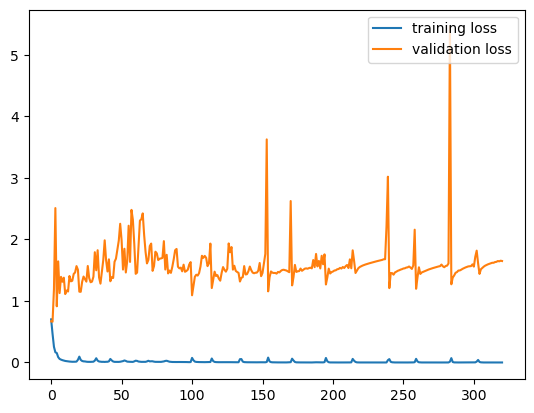

25
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7443 loss_val: 0.6427 time: 16.0913s
 Epoch: 0001 loss_train: 0.5198 loss_val: 0.6936 time: 14.1400s
 Epoch: 0002 loss_train: 0.3026 loss_val: 1.2516 time: 15.1914s
 Epoch: 0003 loss_train: 0.1823 loss_val: 1.6025 time: 14.5294s
 Epoch: 0004 loss_train: 0.1582 loss_val: 1.7786 time: 13.8630s
 Epoch: 0005 loss_train: 0.0939 loss_val: 1.2468 time: 14.0851s
 Epoch: 0006 loss_train: 0.0600 loss_val: 1.4431 time: 13.2786s
 Epoch: 0007 loss_train: 0.0383 loss_val: 1.0571 time: 13.6676s
 Epoch: 0008 loss_train: 0.0246 loss_val: 1.2346 time: 14.2835s
 Epoch: 0009 loss_train: 0.0152 loss_val: 0.9839 time: 14.0528s
 Epoch: 0010 loss_train: 0.0109 loss_val: 1.0393 time: 14.7743s
 Epoch: 0011 loss_train: 0.0048 loss_val: 1.1524 time: 15.2911s
 Epoch: 0012 loss_train: 0.0017 loss_val: 0.9871 time: 13.8746s
 Epoch: 0013 loss_train: 0.0006 loss_val: 0.9816 time: 13.4960s
 Epoch: 0014 loss_train: 0.0004 loss_val: 0.9859 time: 15.0144s
 Epoch: 0015 loss_train: 0.0003 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 1.4349 time: 13.2918s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.4390 time: 13.3712s
 Epoch: 0131 loss_train: 0.0000 loss_val: 1.4432 time: 13.2375s
 Epoch: 0132 loss_train: 0.0000 loss_val: 1.4474 time: 13.5531s
 Epoch: 0133 loss_train: 0.0000 loss_val: 1.4515 time: 14.1273s
 Epoch: 0134 loss_train: 0.0000 loss_val: 1.4557 time: 14.1446s
 Epoch: 0135 loss_train: 0.0000 loss_val: 1.4600 time: 12.8603s
 Epoch: 0136 loss_train: 0.0000 loss_val: 1.4642 time: 13.7015s
 Epoch: 0137 loss_train: 0.0000 loss_val: 1.4683 time: 14.0859s
 Epoch: 0138 loss_train: 0.0000 loss_val: 1.4726 time: 13.7901s
 Epoch: 0139 loss_train: 0.0000 loss_val: 1.4768 time: 13.4022s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.4811 time: 12.9354s
 Epoch: 0141 loss_train: 0.0000 loss_val: 1.4851 time: 13.8936s
 Epoch: 0142 loss_train: 0.0000 loss_val: 1.4894 time: 13.1921s
 Epoch: 0143 loss_train: 0.0000 loss_val: 1.4937 time: 13.6150s
 Epoch: 0144 loss_train: 0.0000 loss_val

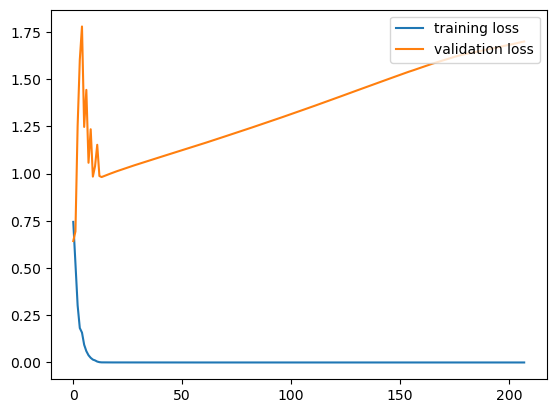

26
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7817 loss_val: 1.0250 time: 14.7883s
 Epoch: 0001 loss_train: 0.5598 loss_val: 0.9136 time: 14.5955s
 Epoch: 0002 loss_train: 0.3538 loss_val: 1.0818 time: 13.3379s
 Epoch: 0003 loss_train: 0.2107 loss_val: 1.2605 time: 15.7546s
 Epoch: 0004 loss_train: 0.1979 loss_val: 1.1422 time: 15.1418s
 Epoch: 0005 loss_train: 0.1362 loss_val: 2.1049 time: 14.0534s
 Epoch: 0006 loss_train: 0.1092 loss_val: 1.7691 time: 14.6660s
 Epoch: 0007 loss_train: 0.0767 loss_val: 1.2097 time: 15.3428s
 Epoch: 0008 loss_train: 0.0637 loss_val: 1.5376 time: 15.3943s
 Epoch: 0009 loss_train: 0.0524 loss_val: 1.2863 time: 15.5673s
 Epoch: 0010 loss_train: 0.0471 loss_val: 1.6152 time: 15.3701s
 Epoch: 0011 loss_train: 0.0387 loss_val: 1.6118 time: 15.9237s
 Epoch: 0012 loss_train: 0.0302 loss_val: 1.4779 time: 14.9158s
 Epoch: 0013 loss_train: 0.0250 loss_val: 1.4191 time: 13.8635s
 Epoch: 0014 loss_train: 0.0227 loss_val: 1.2911 time: 15.1670s
 Epoch: 0015 loss_train: 0.0207 loss_val

 Epoch: 0129 loss_train: 0.0083 loss_val: 1.7588 time: 12.9886s
 Epoch: 0130 loss_train: 0.0094 loss_val: 1.7380 time: 12.0811s
 Epoch: 0131 loss_train: 0.0091 loss_val: 1.8151 time: 12.4688s
 Epoch: 0132 loss_train: 0.0086 loss_val: 1.7803 time: 12.6955s
 Epoch: 0133 loss_train: 0.0087 loss_val: 1.9304 time: 12.3111s
 Epoch: 0134 loss_train: 0.0093 loss_val: 1.9151 time: 12.2261s
 Epoch: 0135 loss_train: 0.0077 loss_val: 1.9202 time: 12.2317s
 Epoch: 0136 loss_train: 0.0082 loss_val: 1.9294 time: 12.3587s
 Epoch: 0137 loss_train: 0.0089 loss_val: 1.8786 time: 12.3777s
 Epoch: 0138 loss_train: 0.0079 loss_val: 1.8896 time: 12.0135s
 Epoch: 0139 loss_train: 0.0074 loss_val: 1.8772 time: 11.8128s
 Epoch: 0140 loss_train: 0.0071 loss_val: 1.9097 time: 11.8815s
 Epoch: 0141 loss_train: 0.0071 loss_val: 1.9417 time: 13.2156s
 Epoch: 0142 loss_train: 0.0078 loss_val: 1.9337 time: 12.3917s
 Epoch: 0143 loss_train: 0.0077 loss_val: 2.1223 time: 11.8722s
 Epoch: 0144 loss_train: 0.0421 loss_val

 Epoch: 0258 loss_train: 0.0009 loss_val: 1.6952 time: 11.5663s
 Epoch: 0259 loss_train: 0.0006 loss_val: 1.7132 time: 11.5547s
 Epoch: 0260 loss_train: 0.0005 loss_val: 1.7308 time: 11.2303s
 Epoch: 0261 loss_train: 0.0004 loss_val: 1.7500 time: 11.0313s
 Epoch: 0262 loss_train: 0.0003 loss_val: 1.7598 time: 11.1321s
 Epoch: 0263 loss_train: 0.0003 loss_val: 1.7742 time: 11.0639s
 Epoch: 0264 loss_train: 0.0002 loss_val: 1.7811 time: 11.4060s
 Epoch: 0265 loss_train: 0.0002 loss_val: 1.7936 time: 11.2256s
 Epoch: 0266 loss_train: 0.0002 loss_val: 1.8000 time: 11.0369s
 Epoch: 0267 loss_train: 0.0001 loss_val: 1.8096 time: 11.2282s
 Epoch: 0268 loss_train: 0.0001 loss_val: 1.8171 time: 11.3879s
 Epoch: 0269 loss_train: 0.0001 loss_val: 1.8271 time: 11.9874s
 Epoch: 0270 loss_train: 0.0001 loss_val: 1.8342 time: 11.1970s
 Epoch: 0271 loss_train: 0.0001 loss_val: 1.8433 time: 11.3747s
 Epoch: 0272 loss_train: 0.0001 loss_val: 1.8492 time: 11.2859s
 Epoch: 0273 loss_train: 0.0001 loss_val

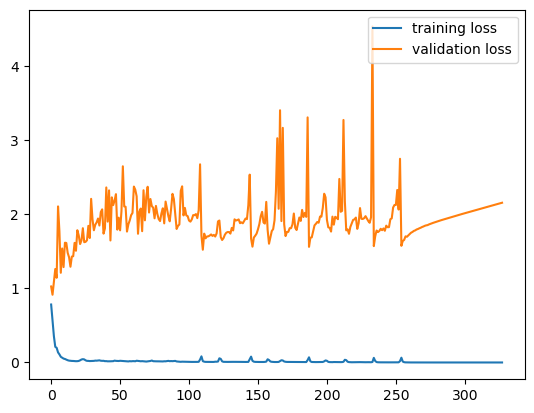

27
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7430 loss_val: 0.8782 time: 12.1034s
 Epoch: 0001 loss_train: 0.5023 loss_val: 0.6530 time: 11.5149s
 Epoch: 0002 loss_train: 0.3306 loss_val: 1.2234 time: 12.2294s
 Epoch: 0003 loss_train: 0.2126 loss_val: 1.3266 time: 11.8692s
 Epoch: 0004 loss_train: 0.1764 loss_val: 1.1067 time: 11.9614s
 Epoch: 0005 loss_train: 0.1247 loss_val: 1.1352 time: 12.1263s
 Epoch: 0006 loss_train: 0.0823 loss_val: 1.1416 time: 11.8672s
 Epoch: 0007 loss_train: 0.0570 loss_val: 1.2582 time: 11.9193s
 Epoch: 0008 loss_train: 0.0415 loss_val: 1.1035 time: 11.9921s
 Epoch: 0009 loss_train: 0.0378 loss_val: 1.0496 time: 11.8799s
 Epoch: 0010 loss_train: 0.0297 loss_val: 1.1229 time: 11.9435s
 Epoch: 0011 loss_train: 0.0248 loss_val: 1.2614 time: 11.8596s
 Epoch: 0012 loss_train: 0.0214 loss_val: 1.5185 time: 12.0687s
 Epoch: 0013 loss_train: 0.0194 loss_val: 1.2925 time: 12.3203s
 Epoch: 0014 loss_train: 0.0206 loss_val: 1.1864 time: 12.3711s
 Epoch: 0015 loss_train: 0.0222 loss_val

 Epoch: 0129 loss_train: 0.0065 loss_val: 1.3548 time: 12.0038s
 Epoch: 0130 loss_train: 0.0060 loss_val: 1.4160 time: 12.0158s
 Epoch: 0131 loss_train: 0.0056 loss_val: 1.4577 time: 11.8293s
 Epoch: 0132 loss_train: 0.0054 loss_val: 1.5274 time: 11.9676s
 Epoch: 0133 loss_train: 0.0057 loss_val: 1.4282 time: 11.9068s
 Epoch: 0134 loss_train: 0.0068 loss_val: 1.4918 time: 12.1399s
 Epoch: 0135 loss_train: 0.0118 loss_val: 1.3294 time: 11.9759s
 Epoch: 0136 loss_train: 0.0119 loss_val: 1.4713 time: 12.1205s
 Epoch: 0137 loss_train: 0.0183 loss_val: 1.8243 time: 11.9362s
 Epoch: 0138 loss_train: 0.0384 loss_val: 1.4386 time: 11.7447s
 Epoch: 0139 loss_train: 0.0206 loss_val: 1.6467 time: 11.9925s
 Epoch: 0140 loss_train: 0.0103 loss_val: 1.3352 time: 12.0106s
 Epoch: 0141 loss_train: 0.0071 loss_val: 1.4315 time: 12.0916s
 Epoch: 0142 loss_train: 0.0059 loss_val: 1.5116 time: 11.9866s
 Epoch: 0143 loss_train: 0.0055 loss_val: 1.4728 time: 11.6341s
 Epoch: 0144 loss_train: 0.0056 loss_val

 Epoch: 0258 loss_train: 0.0000 loss_val: 1.5506 time: 11.9256s
 Epoch: 0259 loss_train: 0.0000 loss_val: 1.5550 time: 12.0457s
 Epoch: 0260 loss_train: 0.0000 loss_val: 1.5595 time: 11.6204s
 Epoch: 0261 loss_train: 0.0000 loss_val: 1.5638 time: 12.1290s
 Epoch: 0262 loss_train: 0.0000 loss_val: 1.5682 time: 11.9879s
 Epoch: 0263 loss_train: 0.0000 loss_val: 1.5726 time: 11.7096s
 Epoch: 0264 loss_train: 0.0000 loss_val: 1.5769 time: 11.9791s
 Epoch: 0265 loss_train: 0.0000 loss_val: 1.5813 time: 12.0379s
 Epoch: 0266 loss_train: 0.0000 loss_val: 1.5856 time: 12.0847s
 Epoch: 0267 loss_train: 0.0000 loss_val: 1.5899 time: 12.0072s
 Epoch: 0268 loss_train: 0.0000 loss_val: 1.5941 time: 13.6352s
 Epoch: 0269 loss_train: 0.0000 loss_val: 1.5984 time: 11.2218s
 Epoch: 0270 loss_train: 0.0000 loss_val: 1.6026 time: 11.8885s
 Epoch: 0271 loss_train: 0.0000 loss_val: 1.6069 time: 11.5567s
 Epoch: 0272 loss_train: 0.0000 loss_val: 1.6113 time: 11.7424s
 Epoch: 0273 loss_train: 0.0000 loss_val

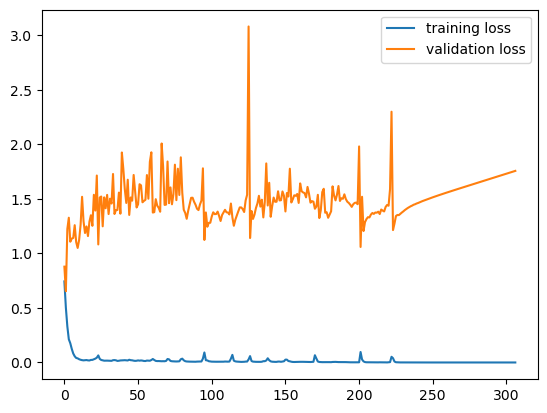

28
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7735 loss_val: 0.8987 time: 11.1975s
 Epoch: 0001 loss_train: 0.5374 loss_val: 0.8653 time: 11.0989s
 Epoch: 0002 loss_train: 0.3331 loss_val: 0.9019 time: 11.8297s
 Epoch: 0003 loss_train: 0.2307 loss_val: 0.9778 time: 12.0603s
 Epoch: 0004 loss_train: 0.1852 loss_val: 1.2145 time: 11.8901s
 Epoch: 0005 loss_train: 0.1334 loss_val: 0.9987 time: 11.5966s
 Epoch: 0006 loss_train: 0.0793 loss_val: 1.2126 time: 11.9801s
 Epoch: 0007 loss_train: 0.0625 loss_val: 1.1859 time: 12.3299s
 Epoch: 0008 loss_train: 0.0468 loss_val: 1.1670 time: 12.0173s
 Epoch: 0009 loss_train: 0.0422 loss_val: 1.2735 time: 11.7636s
 Epoch: 0010 loss_train: 0.0361 loss_val: 1.4605 time: 12.0709s
 Epoch: 0011 loss_train: 0.0336 loss_val: 1.3819 time: 11.5118s
 Epoch: 0012 loss_train: 0.0287 loss_val: 1.9507 time: 11.5972s
 Epoch: 0013 loss_train: 0.0279 loss_val: 1.7307 time: 12.1442s
 Epoch: 0014 loss_train: 0.0252 loss_val: 1.3793 time: 12.1447s
 Epoch: 0015 loss_train: 0.0221 loss_val

 Epoch: 0129 loss_train: 0.0068 loss_val: 1.4840 time: 11.3588s
 Epoch: 0130 loss_train: 0.0060 loss_val: 1.5698 time: 11.6793s
 Epoch: 0131 loss_train: 0.0071 loss_val: 1.5072 time: 11.9514s
 Epoch: 0132 loss_train: 0.0220 loss_val: 1.9194 time: 11.5704s
 Epoch: 0133 loss_train: 0.0159 loss_val: 1.9227 time: 11.7437s
 Epoch: 0134 loss_train: 0.0095 loss_val: 2.1005 time: 12.1325s
 Epoch: 0135 loss_train: 0.0085 loss_val: 2.4119 time: 12.4028s
 Epoch: 0136 loss_train: 0.0071 loss_val: 1.7215 time: 11.7364s
 Epoch: 0137 loss_train: 0.0080 loss_val: 1.8265 time: 11.6567s
 Epoch: 0138 loss_train: 0.0067 loss_val: 1.8145 time: 11.9190s
 Epoch: 0139 loss_train: 0.0083 loss_val: 1.8602 time: 11.9099s
 Epoch: 0140 loss_train: 0.0224 loss_val: 1.9665 time: 11.3933s
 Epoch: 0141 loss_train: 0.0334 loss_val: 1.6913 time: 11.9491s
 Epoch: 0142 loss_train: 0.0184 loss_val: 2.2984 time: 11.1553s
 Epoch: 0143 loss_train: 0.0110 loss_val: 1.9068 time: 11.9566s
 Epoch: 0144 loss_train: 0.0070 loss_val

 Epoch: 0258 loss_train: 0.0006 loss_val: 1.6039 time: 12.1167s
 Epoch: 0259 loss_train: 0.0008 loss_val: 1.6540 time: 12.0542s
 Epoch: 0260 loss_train: 0.0026 loss_val: 1.5436 time: 11.8229s
 Epoch: 0261 loss_train: 0.0028 loss_val: 1.7680 time: 11.6722s
 Epoch: 0262 loss_train: 0.0017 loss_val: 1.6607 time: 12.1246s
 Epoch: 0263 loss_train: 0.0043 loss_val: 2.0903 time: 11.9352s
 Epoch: 0264 loss_train: 0.0592 loss_val: 1.2070 time: 11.7982s
 Epoch: 0265 loss_train: 0.0225 loss_val: 1.3655 time: 12.1311s
 Epoch: 0266 loss_train: 0.0046 loss_val: 1.3745 time: 12.1433s
 Epoch: 0267 loss_train: 0.0012 loss_val: 1.4544 time: 11.7531s
 Epoch: 0268 loss_train: 0.0006 loss_val: 1.4692 time: 12.1193s
 Epoch: 0269 loss_train: 0.0004 loss_val: 1.4864 time: 12.0868s
 Epoch: 0270 loss_train: 0.0004 loss_val: 1.5003 time: 12.0945s
 Epoch: 0271 loss_train: 0.0003 loss_val: 1.5109 time: 12.0594s
 Epoch: 0272 loss_train: 0.0002 loss_val: 1.5265 time: 11.7376s
 Epoch: 0273 loss_train: 0.0002 loss_val

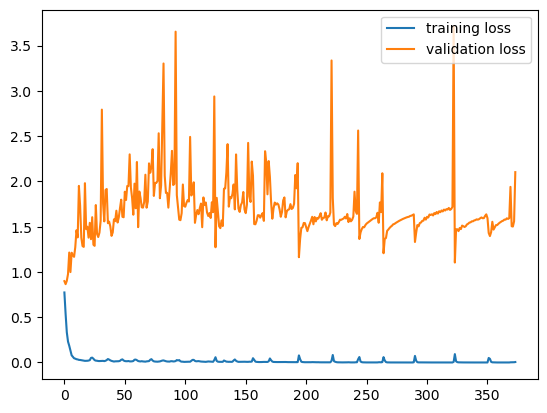

29
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7806 loss_val: 0.9483 time: 11.7043s
 Epoch: 0001 loss_train: 0.5526 loss_val: 0.9186 time: 11.2956s
 Epoch: 0002 loss_train: 0.3591 loss_val: 1.5607 time: 11.0364s
 Epoch: 0003 loss_train: 0.2146 loss_val: 1.1611 time: 11.2774s
 Epoch: 0004 loss_train: 0.1916 loss_val: 2.0661 time: 11.0825s
 Epoch: 0005 loss_train: 0.1468 loss_val: 1.2085 time: 11.4514s
 Epoch: 0006 loss_train: 0.0933 loss_val: 1.2124 time: 11.2037s
 Epoch: 0007 loss_train: 0.0578 loss_val: 1.1573 time: 11.2424s
 Epoch: 0008 loss_train: 0.0425 loss_val: 1.0735 time: 11.3918s
 Epoch: 0009 loss_train: 0.0358 loss_val: 1.2205 time: 11.1672s
 Epoch: 0010 loss_train: 0.0320 loss_val: 1.4578 time: 11.2071s
 Epoch: 0011 loss_train: 0.0311 loss_val: 1.2739 time: 11.0695s
 Epoch: 0012 loss_train: 0.0270 loss_val: 1.1787 time: 11.4192s
 Epoch: 0013 loss_train: 0.0228 loss_val: 1.3430 time: 10.7700s
 Epoch: 0014 loss_train: 0.0208 loss_val: 1.5007 time: 11.4075s
 Epoch: 0015 loss_train: 0.0175 loss_val

 Epoch: 0129 loss_train: 0.0041 loss_val: 1.5474 time: 11.3208s
 Epoch: 0130 loss_train: 0.0212 loss_val: 2.0057 time: 11.4803s
 Epoch: 0131 loss_train: 0.0318 loss_val: 1.4761 time: 11.4978s
 Epoch: 0132 loss_train: 0.0155 loss_val: 1.5165 time: 11.0673s
 Epoch: 0133 loss_train: 0.0065 loss_val: 1.5450 time: 11.3195s
 Epoch: 0134 loss_train: 0.0041 loss_val: 1.5199 time: 11.3389s
 Epoch: 0135 loss_train: 0.0036 loss_val: 1.5121 time: 11.4637s
 Epoch: 0136 loss_train: 0.0037 loss_val: 1.4357 time: 11.6150s
 Epoch: 0137 loss_train: 0.0040 loss_val: 1.6920 time: 11.4872s
 Epoch: 0138 loss_train: 0.0039 loss_val: 1.8063 time: 11.2538s
 Epoch: 0139 loss_train: 0.0040 loss_val: 1.7066 time: 11.3280s
 Epoch: 0140 loss_train: 0.0030 loss_val: 1.5994 time: 11.4824s
 Epoch: 0141 loss_train: 0.0036 loss_val: 1.7324 time: 11.2534s
 Epoch: 0142 loss_train: 0.0036 loss_val: 1.6128 time: 11.1833s
 Epoch: 0143 loss_train: 0.0027 loss_val: 1.7473 time: 11.2161s
 Epoch: 0144 loss_train: 0.0039 loss_val

 Epoch: 0258 loss_train: 0.0000 loss_val: 1.7884 time: 10.9678s
 Epoch: 0259 loss_train: 0.0000 loss_val: 1.7927 time: 11.2446s
 Epoch: 0260 loss_train: 0.0000 loss_val: 1.7970 time: 11.1251s
 Epoch: 0261 loss_train: 0.0000 loss_val: 1.8009 time: 10.8734s
 Epoch: 0262 loss_train: 0.0000 loss_val: 1.8051 time: 10.8613s
 Epoch: 0263 loss_train: 0.0000 loss_val: 1.8093 time: 11.2217s
 Epoch: 0264 loss_train: 0.0000 loss_val: 1.8136 time: 10.9374s
 Epoch: 0265 loss_train: 0.0000 loss_val: 1.8178 time: 11.2085s
 Epoch: 0266 loss_train: 0.0000 loss_val: 1.8219 time: 10.9837s
 Epoch: 0267 loss_train: 0.0000 loss_val: 1.8261 time: 11.8732s
 Epoch: 0268 loss_train: 0.0000 loss_val: 1.8304 time: 11.0815s
 Epoch: 0269 loss_train: 0.0000 loss_val: 1.8344 time: 11.0694s
 Epoch: 0270 loss_train: 0.0000 loss_val: 1.8386 time: 11.4788s
 Epoch: 0271 loss_train: 0.0000 loss_val: 1.8428 time: 10.9356s
 Epoch: 0272 loss_train: 0.0000 loss_val: 1.8470 time: 11.1606s
 Epoch: 0273 loss_train: 0.0000 loss_val

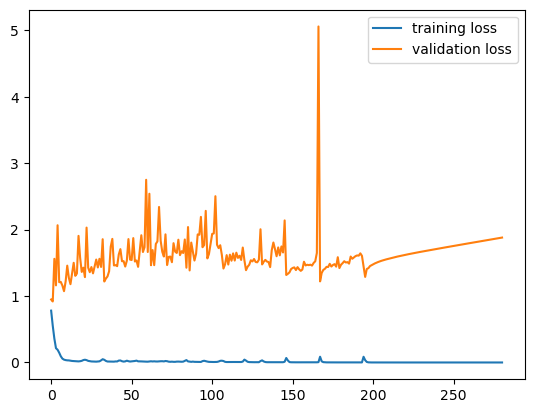

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7068 loss_val: 0.6100 time: 11.6140s
 Epoch: 0001 loss_train: 0.4771 loss_val: 0.6020 time: 11.0951s
 Epoch: 0002 loss_train: 0.2907 loss_val: 0.9991 time: 10.8762s
 Epoch: 0003 loss_train: 0.1846 loss_val: 0.9486 time: 10.9135s
 Epoch: 0004 loss_train: 0.1486 loss_val: 1.1026 time: 10.8703s
 Epoch: 0005 loss_train: 0.1136 loss_val: 2.6597 time: 11.4030s
 Epoch: 0006 loss_train: 0.0760 loss_val: 1.3489 time: 11.6014s
 Epoch: 0007 loss_train: 0.0440 loss_val: 1.0119 time: 10.8846s
 Epoch: 0008 loss_train: 0.0268 loss_val: 0.9721 time: 10.6890s
 Epoch: 0009 loss_train: 0.0213 loss_val: 1.2032 time: 10.7740s
 Epoch: 0010 loss_train: 0.0176 loss_val: 1.2725 time: 10.7334s
 Epoch: 0011 loss_train: 0.0158 loss_val: 1.1564 time: 10.7771s
 Epoch: 0012 loss_train: 0.0138 loss_val: 1.2360 time: 10.6994s
 Epoch: 0013 loss_train: 0.0123 loss_val: 1.2189 time: 11.0606s
 Epoch: 0014 loss_train: 0.0111 loss_val: 1.2554 time: 11.9023s
 Epoch: 0015 loss_train: 0.0114 loss_val

 Epoch: 0129 loss_train: 0.0132 loss_val: 1.3471 time: 11.8732s
 Epoch: 0130 loss_train: 0.0081 loss_val: 1.4658 time: 11.8444s
 Epoch: 0131 loss_train: 0.0045 loss_val: 1.4253 time: 11.2983s
 Epoch: 0132 loss_train: 0.0033 loss_val: 1.4307 time: 11.0667s
 Epoch: 0133 loss_train: 0.0029 loss_val: 1.4331 time: 11.4522s
 Epoch: 0134 loss_train: 0.0026 loss_val: 1.4389 time: 11.4236s
 Epoch: 0135 loss_train: 0.0025 loss_val: 1.4945 time: 11.5795s
 Epoch: 0136 loss_train: 0.0025 loss_val: 1.4304 time: 11.9020s
 Epoch: 0137 loss_train: 0.0024 loss_val: 1.4117 time: 11.9404s
 Epoch: 0138 loss_train: 0.0026 loss_val: 1.4263 time: 11.7041s
 Epoch: 0139 loss_train: 0.0036 loss_val: 1.3631 time: 11.4490s
 Epoch: 0140 loss_train: 0.0038 loss_val: 1.3958 time: 11.1306s
 Epoch: 0141 loss_train: 0.0073 loss_val: 1.5853 time: 10.7377s
 Epoch: 0142 loss_train: 0.0530 loss_val: 1.3456 time: 10.7882s
 Epoch: 0143 loss_train: 0.0259 loss_val: 1.3705 time: 11.0404s
 Epoch: 0144 loss_train: 0.0089 loss_val

 Epoch: 0258 loss_train: 0.0002 loss_val: 1.5539 time: 10.9841s
 Epoch: 0259 loss_train: 0.0002 loss_val: 1.5580 time: 10.8756s
 Epoch: 0260 loss_train: 0.0002 loss_val: 1.5737 time: 11.0589s
 Epoch: 0261 loss_train: 0.0002 loss_val: 1.5778 time: 11.8878s
 Epoch: 0262 loss_train: 0.0002 loss_val: 1.5793 time: 11.3001s
 Epoch: 0263 loss_train: 0.0002 loss_val: 1.5908 time: 11.6633s
 Epoch: 0264 loss_train: 0.0002 loss_val: 1.5991 time: 10.8388s
 Epoch: 0265 loss_train: 0.0002 loss_val: 1.6069 time: 11.5334s
 Epoch: 0266 loss_train: 0.0002 loss_val: 1.6197 time: 10.9137s
 Epoch: 0267 loss_train: 0.0002 loss_val: 1.6089 time: 11.2527s
 Epoch: 0268 loss_train: 0.0002 loss_val: 1.6148 time: 10.7558s
 Epoch: 0269 loss_train: 0.0004 loss_val: 1.6377 time: 11.4852s
 Epoch: 0270 loss_train: 0.0010 loss_val: 1.4985 time: 10.7316s
 Epoch: 0271 loss_train: 0.0358 loss_val: 1.8440 time: 10.7281s
 Epoch: 0272 loss_train: 0.0408 loss_val: 1.4424 time: 10.9379s
 Epoch: 0273 loss_train: 0.0096 loss_val

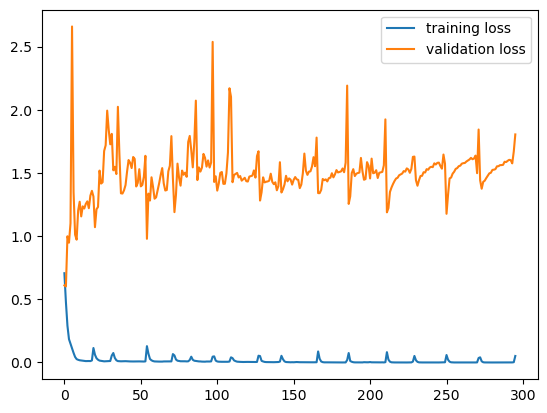

31
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7407 loss_val: 0.6728 time: 11.3752s
 Epoch: 0001 loss_train: 0.5222 loss_val: 0.6353 time: 10.8069s
 Epoch: 0002 loss_train: 0.3058 loss_val: 1.6679 time: 10.6240s
 Epoch: 0003 loss_train: 0.1932 loss_val: 1.3012 time: 10.6420s
 Epoch: 0004 loss_train: 0.1676 loss_val: 1.4736 time: 11.0177s
 Epoch: 0005 loss_train: 0.0929 loss_val: 1.7863 time: 11.2953s
 Epoch: 0006 loss_train: 0.0565 loss_val: 1.1166 time: 10.6919s
 Epoch: 0007 loss_train: 0.0266 loss_val: 1.1317 time: 10.8169s
 Epoch: 0008 loss_train: 0.0138 loss_val: 1.0883 time: 10.6305s
 Epoch: 0009 loss_train: 0.0043 loss_val: 1.0058 time: 10.7540s
 Epoch: 0010 loss_train: 0.0014 loss_val: 0.9857 time: 10.8106s
 Epoch: 0011 loss_train: 0.0007 loss_val: 0.9951 time: 11.1595s
 Epoch: 0012 loss_train: 0.0005 loss_val: 1.0016 time: 11.6559s
 Epoch: 0013 loss_train: 0.0005 loss_val: 1.0081 time: 11.6804s
 Epoch: 0014 loss_train: 0.0004 loss_val: 1.0140 time: 11.3124s
 Epoch: 0015 loss_train: 0.0004 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 1.5386 time: 11.9065s
 Epoch: 0130 loss_train: 0.0000 loss_val: 1.5432 time: 11.9696s
 Epoch: 0131 loss_train: 0.0000 loss_val: 1.5480 time: 11.4349s
 Epoch: 0132 loss_train: 0.0000 loss_val: 1.5524 time: 11.4920s
 Epoch: 0133 loss_train: 0.0000 loss_val: 1.5569 time: 11.2831s
 Epoch: 0134 loss_train: 0.0000 loss_val: 1.5614 time: 11.7446s
 Epoch: 0135 loss_train: 0.0000 loss_val: 1.5662 time: 11.2422s
 Epoch: 0136 loss_train: 0.0000 loss_val: 1.5707 time: 11.2067s
 Epoch: 0137 loss_train: 0.0000 loss_val: 1.5753 time: 11.1636s
 Epoch: 0138 loss_train: 0.0000 loss_val: 1.5799 time: 11.1767s
 Epoch: 0139 loss_train: 0.0000 loss_val: 1.5846 time: 11.2080s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5891 time: 11.1390s
 Epoch: 0141 loss_train: 0.0000 loss_val: 1.5934 time: 11.8584s
 Epoch: 0142 loss_train: 0.0000 loss_val: 1.5982 time: 11.7365s
 Epoch: 0143 loss_train: 0.0000 loss_val: 1.6025 time: 11.9431s
 Epoch: 0144 loss_train: 0.0000 loss_val

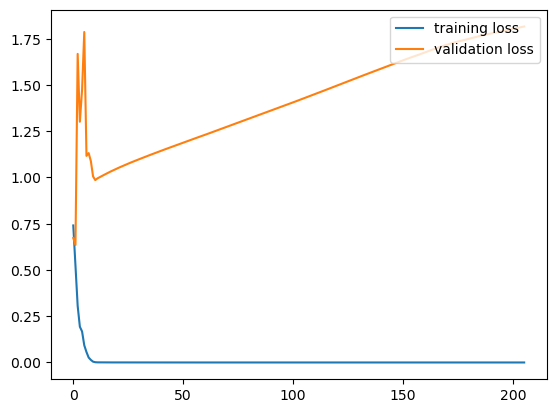

32
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7923 loss_val: 0.6722 time: 11.7774s
 Epoch: 0001 loss_train: 0.5643 loss_val: 0.6474 time: 11.9110s
 Epoch: 0002 loss_train: 0.3505 loss_val: 0.8118 time: 11.3425s
 Epoch: 0003 loss_train: 0.2182 loss_val: 1.4318 time: 10.9699s
 Epoch: 0004 loss_train: 0.1732 loss_val: 1.0104 time: 10.9342s
 Epoch: 0005 loss_train: 0.1306 loss_val: 1.8453 time: 10.9121s
 Epoch: 0006 loss_train: 0.1155 loss_val: 1.6241 time: 11.0595s
 Epoch: 0007 loss_train: 0.0892 loss_val: 1.1737 time: 11.2611s
 Epoch: 0008 loss_train: 0.0677 loss_val: 1.7790 time: 11.3248s
 Epoch: 0009 loss_train: 0.0481 loss_val: 1.5993 time: 11.6103s
 Epoch: 0010 loss_train: 0.0388 loss_val: 1.3981 time: 11.9677s
 Epoch: 0011 loss_train: 0.0334 loss_val: 1.2828 time: 11.0054s
 Epoch: 0012 loss_train: 0.0280 loss_val: 1.3677 time: 11.0971s
 Epoch: 0013 loss_train: 0.0235 loss_val: 1.3932 time: 10.9419s
 Epoch: 0014 loss_train: 0.0206 loss_val: 1.4301 time: 11.0619s
 Epoch: 0015 loss_train: 0.0201 loss_val

 Epoch: 0129 loss_train: 0.0082 loss_val: 1.8030 time: 11.5695s
 Epoch: 0130 loss_train: 0.0095 loss_val: 1.8730 time: 11.2700s
 Epoch: 0131 loss_train: 0.0092 loss_val: 1.8359 time: 12.0106s
 Epoch: 0132 loss_train: 0.0087 loss_val: 1.7415 time: 11.3852s
 Epoch: 0133 loss_train: 0.0079 loss_val: 1.7203 time: 11.2955s
 Epoch: 0134 loss_train: 0.0074 loss_val: 1.8906 time: 11.3261s
 Epoch: 0135 loss_train: 0.0074 loss_val: 2.0073 time: 11.2764s
 Epoch: 0136 loss_train: 0.0079 loss_val: 1.8912 time: 12.7473s
 Epoch: 0137 loss_train: 0.0072 loss_val: 1.9063 time: 12.0829s
 Epoch: 0138 loss_train: 0.0074 loss_val: 1.9403 time: 12.0706s
 Epoch: 0139 loss_train: 0.0091 loss_val: 1.9184 time: 12.1451s
 Epoch: 0140 loss_train: 0.0760 loss_val: 1.3832 time: 11.5761s
 Epoch: 0141 loss_train: 0.0307 loss_val: 1.4671 time: 11.4670s
 Epoch: 0142 loss_train: 0.0109 loss_val: 1.5759 time: 11.5771s
 Epoch: 0143 loss_train: 0.0076 loss_val: 1.5615 time: 11.9249s
 Epoch: 0144 loss_train: 0.0066 loss_val

 Epoch: 0258 loss_train: 0.0022 loss_val: 1.8549 time: 11.3851s
 Epoch: 0259 loss_train: 0.0019 loss_val: 1.7731 time: 11.3814s
 Epoch: 0260 loss_train: 0.0021 loss_val: 1.7458 time: 11.3931s
 Epoch: 0261 loss_train: 0.0016 loss_val: 1.8091 time: 11.3323s
 Epoch: 0262 loss_train: 0.0018 loss_val: 1.9178 time: 12.0387s
 Epoch: 0263 loss_train: 0.0633 loss_val: 2.6032 time: 12.0267s
 Epoch: 0264 loss_train: 0.0311 loss_val: 1.4324 time: 12.0729s
 Epoch: 0265 loss_train: 0.0071 loss_val: 1.5118 time: 12.9806s
 Epoch: 0266 loss_train: 0.0018 loss_val: 1.5634 time: 11.9707s
 Epoch: 0267 loss_train: 0.0007 loss_val: 1.5873 time: 12.0178s
 Epoch: 0268 loss_train: 0.0005 loss_val: 1.6129 time: 11.5761s
 Epoch: 0269 loss_train: 0.0004 loss_val: 1.6265 time: 11.4074s
 Epoch: 0270 loss_train: 0.0003 loss_val: 1.6379 time: 11.3804s
 Epoch: 0271 loss_train: 0.0002 loss_val: 1.6490 time: 11.4400s
 Epoch: 0272 loss_train: 0.0002 loss_val: 1.6599 time: 11.8035s
 Epoch: 0273 loss_train: 0.0002 loss_val

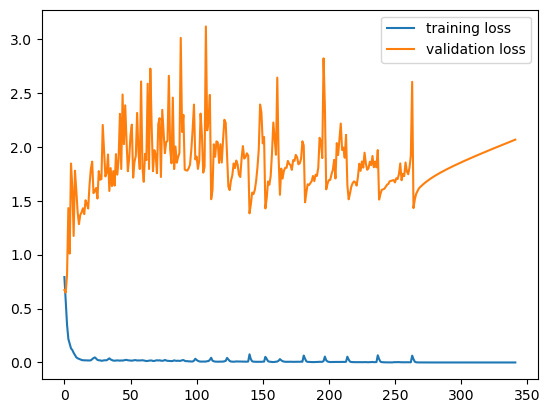

33
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Epoch: 0271 loss_train: 0.0002 loss_val: 1.4297 time: 11.5014s
 Epoch: 0272 loss_train: 0.0002 loss_val: 1.4321 time: 11.3040s
 Epoch: 0273 loss_train: 0.0002 loss_val: 1.4425 time: 11.2918s
 Epoch: 0274 loss_train: 0.0002 loss_val: 1.4407 time: 11.8322s
 Epoch: 0275 loss_train: 0.0002 loss_val: 1.4572 time: 11.4416s
 Epoch: 0276 loss_train: 0.0002 loss_val: 1.4507 time: 11.8669s
 Epoch: 0277 loss_train: 0.0003 loss_val: 1.4784 time: 11.8951s
 Epoch: 0278 loss_train: 0.0011 loss_val: 1.5343 time: 11.4562s
 Epoch: 0279 loss_train: 0.0329 loss_val: 1.4847 time: 11.3013s
 Epoch: 0280 loss_train: 0.0454 loss_val: 1.3305 time: 11.3793s
 Epoch: 0281 loss_train: 0.0133 loss_val: 1.3682 time: 11.3038s
 Epoch: 0282 loss_train: 0.0035 loss_val: 1.3901 time: 11.8858s
 Epoch: 0283 loss_train: 0.0015 loss_val: 1.3354 time: 11.2861s
 Epoch: 0284 loss_train: 0.0007 loss_val: 1.3356 time: 11.8719s
 Epoch: 0285 loss_train: 0.0007 loss_val: 1.3562 time: 11.1419s
 Epoch: 0286 loss_train: 0.0004 loss_val

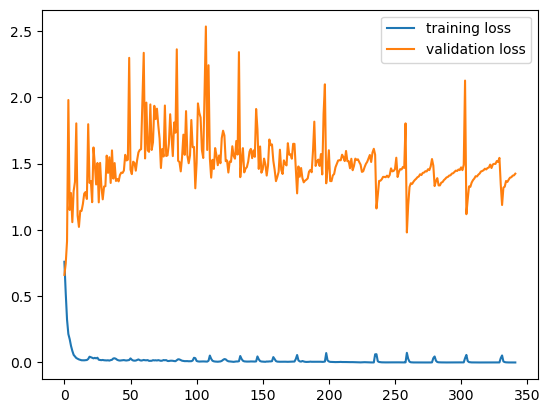

35
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1555268/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1555268/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.7677 loss_val: 0.7485 time: 11.8112s
 Epoch: 0001 loss_train: 0.5265 loss_val: 0.8020 time: 11.5284s
 Epoch: 0002 loss_train: 0.3250 loss_val: 1.1133 time: 11.3869s
 Epoch: 0003 loss_train: 0.2116 loss_val: 1.4290 time: 11.6137s
 Epoch: 0004 loss_train: 0.1660 loss_val: 1.6538 time: 11.5488s
 Epoch: 0005 loss_train: 0.1025 loss_val: 1.7693 time: 12.2405s
 Epoch: 0006 loss_train: 0.0729 loss_val: 1.8866 time: 12.0425s
 Epoch: 0007 loss_train: 0.0574 loss_val: 1.2263 time: 11.7800s
 Epoch: 0008 loss_train: 0.0456 loss_val: 1.4911 time: 11.8290s
 Epoch: 0009 loss_train: 0.0401 loss_val: 1.6866 time: 12.1093s
 Epoch: 0010 loss_train: 0.0328 loss_val: 1.7057 time: 11.8094s
 Epoch: 0011 loss_train: 0.0296 loss_val: 1.8919 time: 11.9649s
 Epoch: 0012 loss_train: 0.0284 loss_val: 1.5382 time: 11.6618s
 Epoch: 0013 loss_train: 0.0266 loss_val: 1.3357 time: 11.7082s
 Epoch: 0014 loss_train: 0.0217 loss_val: 1.3118 time: 12.0703s
 Epoch: 0015 loss_train: 0.0198 loss_val

 Epoch: 0129 loss_train: 0.0171 loss_val: 1.9445 time: 11.5935s
 Epoch: 0130 loss_train: 0.0195 loss_val: 1.6544 time: 12.0337s
 Epoch: 0131 loss_train: 0.0187 loss_val: 1.6635 time: 11.6232s
 Epoch: 0132 loss_train: 0.0123 loss_val: 1.6626 time: 11.6148s
 Epoch: 0133 loss_train: 0.0099 loss_val: 1.6497 time: 11.6053s
 Epoch: 0134 loss_train: 0.0095 loss_val: 1.7398 time: 11.5755s
 Epoch: 0135 loss_train: 0.0079 loss_val: 1.9978 time: 11.9533s
 Epoch: 0136 loss_train: 0.0104 loss_val: 1.7679 time: 12.1338s
 Epoch: 0137 loss_train: 0.0080 loss_val: 1.6702 time: 12.1579s
 Epoch: 0138 loss_train: 0.0076 loss_val: 1.6469 time: 12.1132s
 Epoch: 0139 loss_train: 0.0078 loss_val: 1.6796 time: 12.3248s
 Epoch: 0140 loss_train: 0.0073 loss_val: 1.7211 time: 12.1981s
 Epoch: 0141 loss_train: 0.0074 loss_val: 2.1860 time: 12.0934s
 Epoch: 0142 loss_train: 0.0072 loss_val: 1.7326 time: 11.7462s
 Epoch: 0143 loss_train: 0.0081 loss_val: 2.4486 time: 12.2473s
 Epoch: 0144 loss_train: 0.0176 loss_val

 Epoch: 0258 loss_train: 0.0004 loss_val: 1.6786 time: 12.5038s
 Epoch: 0259 loss_train: 0.0042 loss_val: 2.3062 time: 12.2880s
 Epoch: 0260 loss_train: 0.0547 loss_val: 1.4781 time: 12.2729s
 Epoch: 0261 loss_train: 0.0233 loss_val: 1.5187 time: 12.1649s
 Epoch: 0262 loss_train: 0.0117 loss_val: 1.5850 time: 12.2881s
 Epoch: 0263 loss_train: 0.0031 loss_val: 1.5346 time: 12.3258s
 Epoch: 0264 loss_train: 0.0016 loss_val: 1.5283 time: 12.2135s
 Epoch: 0265 loss_train: 0.0010 loss_val: 1.5390 time: 12.1139s
 Epoch: 0266 loss_train: 0.0008 loss_val: 1.5860 time: 11.8857s
 Epoch: 0267 loss_train: 0.0008 loss_val: 1.5664 time: 12.0025s
 Epoch: 0268 loss_train: 0.0007 loss_val: 1.5886 time: 12.2100s
 Epoch: 0269 loss_train: 0.0007 loss_val: 1.5892 time: 11.4050s
 Epoch: 0270 loss_train: 0.0004 loss_val: 1.6083 time: 11.6829s
 Epoch: 0271 loss_train: 0.0004 loss_val: 1.6144 time: 12.2222s
 Epoch: 0272 loss_train: 0.0004 loss_val: 1.6237 time: 12.3382s
 Epoch: 0273 loss_train: 0.0003 loss_val

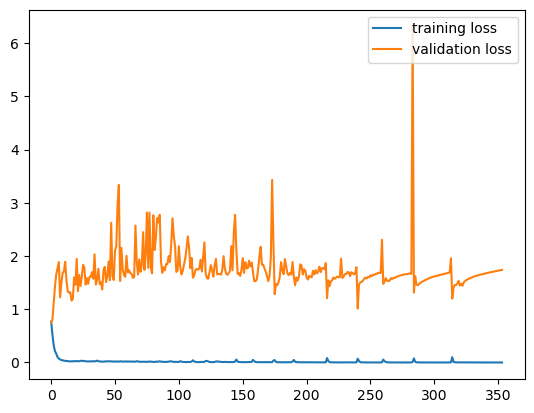

In [10]:
for sample_s in range(nSamples):
    print(sample_s)
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])

    p_curr='chromatin'

    print(p_curr)


    np.random.seed(sample_s+6)
    pctVal=0.1

    allIdx=np.arange(conditions_all_samples_s.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr)
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr)
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr)
    if not os.path.exists(logsavepath_train_curr):
        os.mkdir(logsavepath_train_curr)
    if not os.path.exists(modelsavepath_train_curr):
        os.mkdir(modelsavepath_train_curr)
    if not os.path.exists(plotsavepath_train_curr):
        os.mkdir(plotsavepath_train_curr)
    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))
    
    if not os.path.exists(logsavepath_train_curr):
        os.mkdir(logsavepath_train_curr)
    if not os.path.exists(modelsavepath_train_curr):
        os.mkdir(modelsavepath_train_curr)
    if not os.path.exists(plotsavepath_train_curr):
        os.mkdir(plotsavepath_train_curr)

    cnames,revIdx_c,cCounts=np.unique(conditions_all_samples_s[trainIdx],return_inverse=True,return_counts=True)
    clfWeight=1/cCounts
    clfWeight=clfWeight/np.sum(clfWeight)
    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
    cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=cnames.size)
        model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=cnames.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
    model.cuda()
    optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss=[np.inf]*epochs
    val_loss=[np.inf]*epochs

    t_ep=time.time()

    epCounts=0
    for ep in range(epochs):
        train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,imgsC_all_samples_s[trainIdx],imgsC_all_samples_s[valIdx],torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

        if ep>50 and val_loss[ep]>=val_loss[ep-50]:
            epCounts+=1

        if epCounts>150:
            break


        if ep%saveFreq == (saveFreq-1):
            torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


        model.cuda()
        torch.cuda.empty_cache()
    print(' total time: {:.4f}s'.format(time.time() - t_ep))


    with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
        pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
        pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


    plt.plot(np.arange(epochs),train_loss)
    plt.plot(np.arange(epochs),val_loss)
    plt.legend(['training loss','validation loss'],loc='upper right')
    plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
    plt.show()



In [11]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

In [12]:
p_curr='chromatin'
res_val=np.zeros((nSamples,cnames.size,cnames.size))
correctCount_val=[None]*nSamples

print(p_curr)

for sample_s in range(nSamples):
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])

    p_curr='chromatin'

    print(p_curr)


    np.random.seed(sample_s+6)
    pctVal=0.1

    allIdx=np.arange(conditions_all_samples_s.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)

    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))

    cnames,revIdx_c,cCounts=np.unique(conditions_all_samples_s[trainIdx],return_inverse=True,return_counts=True)
    clfWeight=1/cCounts
    clfWeight=clfWeight/np.sum(clfWeight)
    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
    cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=cnames.size)
        model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=cnames.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
    model.cuda()

    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
        val_loss=pickle.load(output)
    minlossepoch=np.argmin(val_loss)
    minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
        if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
            minlossepoch_saved=minlossepoch_saved+saveFreq
        else:
            minlossepoch_saved=minlossepoch_saved-saveFreq
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

    #validation samples
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        pred_curr=np.array([])
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            val_labels=torch.tensor(revIdx_c_val[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]).cuda().long()
            valInput=torch.tensor(imgsC_all_samples_s[valIdx_i]).cuda().float()


            pred = model(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()
            pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))

        loss_val_all=loss_val_all/nvalBatches

    print('loss_val: {:.4f}'.format(loss_val_all))
    correctCount=np.sum(pred_curr==revIdx_c_val)/pred_curr.size
    print('acc: {:.4f}'.format(correctCount))

    pred_curr=pred_curr.astype(int)
    res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr],plotsavepath_train_curr,'confusion_val',False,addname='',ctorder=None,vmin=0,vmax=1)
    correctCount_val[sample_s]=correctCount
    
    
with open(os.path.join(plotsavepath_train_p,'acc_val_moreSamples'), 'wb') as output:
    pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(plotsavepath_train_p,'confusion_val_moreSamples'), 'wb') as output:
    pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)




chromatin
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin
loss_val: 1.5860
acc: 0.7446
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dap

HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin
loss_val: 1.1832
acc: 0.7569
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83

HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin
loss_val: 1.9531
acc: 0.6894
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P2